# Extension 6.1: Adaptive Re-ranking Strategy

## 1. Threshold Selection and Training
In this section, we define what a "hard query" is and determine an optimal inlier threshold $\tau$.
The goal is to stop the re-ranking process if the first retrieved candidate already shows a high number of inliers,
assuming the prediction is correct.

**Strategy:**
* Use **SVOX Sun Train** and **SVOX Night Train** to analyze the inlier distribution.
* Find the threshold $\tau$ that maximizes the F1-score or balances Precision/Recall on the training set.

Estrazione dataset

In [ ]:
import zipfile
import os
from tqdm import tqdm

# ==============================================================================
# CONFIGURAZIONE
# ==============================================================================
BASE_DRIVE_PATH = "/content/drive/MyDrive"

# Lista dei dataset: (Nome File Zip, Cartella di Destinazione)
datasets_list = [
    ("sf_xs.zip", "/content/sf_xs"),
    ("svox.zip", "/content/svox"),
    ("tokyo_xs.zip", "/content/tokyo_xs")
]

# ==============================================================================
# SCRIPT DI ESTRAZIONE
# ==============================================================================
def unzip_dataset(zip_name, extract_to):
    zip_path = os.path.join(BASE_DRIVE_PATH, zip_name)

    if not os.path.exists(zip_path):
        print(f"❌ SALTATO: Non trovo {zip_name} in {BASE_DRIVE_PATH}")
        return

    print(f"\n📂 Estrazione di {zip_name} in {extract_to}...")

    os.makedirs(extract_to, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # tqdm per barra di progresso
            for member in tqdm(zip_ref.infolist(), desc=f"Estraendo {zip_name}"):
                zip_ref.extract(member, extract_to)
        print(f"✅ {zip_name} estratto correttamente!")
    except zipfile.BadZipFile:
        print(f"❌ ERRORE: Il file {zip_name} sembra corrotto.")
    except Exception as e:
        print(f"❌ ERRORE Generico su {zip_name}: {e}")

# ==============================================================================
# ESECUZIONE LOOP
# ==============================================================================
if __name__ == "__main__":
    print(f"🚀 Inizio estrazione di {len(datasets_list)} dataset...")

    for zip_file, dest_folder in datasets_list:
        unzip_dataset(zip_file, dest_folder)

    print("\n✨ TUTTO COMPLETATO! I dataset sono pronti in /content/")

🚀 Inizio estrazione di 3 dataset...

📂 Estrazione di sf_xs.zip in /content/sf_xs...


Estraendo sf_xs.zip: 100%|██████████| 103869/103869 [00:38<00:00, 2724.57it/s]


✅ sf_xs.zip estratto correttamente!

📂 Estrazione di svox.zip in /content/svox...


Estraendo svox.zip: 100%|██████████| 104864/104864 [01:41<00:00, 1031.06it/s]


✅ svox.zip estratto correttamente!

📂 Estrazione di tokyo_xs.zip in /content/tokyo_xs...


Estraendo tokyo_xs.zip: 100%|██████████| 13090/13090 [00:04<00:00, 3030.32it/s]

✅ tokyo_xs.zip estratto correttamente!

✨ TUTTO COMPLETATO! I dataset sono pronti in /content/


Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive

print("🔌 Smontaggio di Google Drive in corso...")

try:
    # Questo comando forza la scrittura dei dati in sospeso e smonta il drive
    drive.flush_and_unmount()
    print("✅ Google Drive smontato con successo!")
except Exception as e:
    print(f"⚠️ Errore (forse il Drive non era montato): {e}")

🔌 Smontaggio di Google Drive in corso...
✅ Google Drive smontato con successo!


## Selezione della Soglia (SVOX Sun Train)
In questa fase analizziamo i dati di addestramento per definire cosa rende una query "facile" o "difficile". Utilizziamo l'F1-Score come metrica di riferimento perché bilancia la precisione (non scambiare un errore per un match facile) e la recall (identificare correttamente i match facili per risparmiare calcoli).

## LoFTR

### Come trovo TAU?
Per capire se siamo incerti, usiamo il numero di Inliers (i punti in comune trovati tra le due immagini).

1. Il modello fa una prima previsione veloce (Retrieval).
2. Contiamo quanti punti combaciano (Inliers) con la prima immagine trovata.
3. Confrontiamo questo numero con una soglia di sicurezza, chiamata $\tau$ ("tau"):
* Se Inliers > $\tau$ (Tanti punti in comune) $\rightarrow$ La query è FACILE. Ci fidiamo subito, risparmiando tempo.
* Se Inliers $\le \tau$ (Pochi punti in comune) $\rightarrow$ La query è DIFFICILE. Non ci fidiamo, quindi attiviamo il Re-ranking per controllare meglio.





### TAU SVOX Sun Train LoFTR

📂 Base Path: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_sun_train


Lettura .torch: 100%|██████████| 712/712 [04:09<00:00,  2.85it/s]


✅ Dati caricati: 712 query comuni trovate.


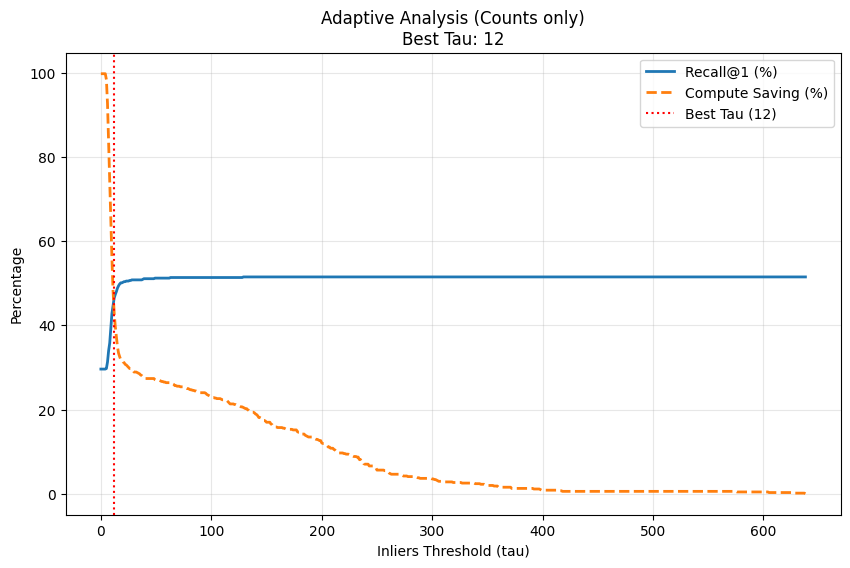


--- RISULTATI ADAPTIVE (Best Tau: 12) ---
Tau   | Recall     | Saving     | F2-Score  
--------------------------------------------------
0     | 29.63%     | 99.86%     | 0.3449     
5     | 29.78%     | 98.46%     | 0.3460     
10    | 42.84%     | 56.04%     | 0.4496     
12    | 46.49%     | 43.12%     | 0.4577     ⭐ BEST
15    | 48.88%     | 34.97%     | 0.4528     
20    | 50.28%     | 31.32%     | 0.4485     
25    | 50.56%     | 30.06%     | 0.4449     
30    | 50.84%     | 28.93%     | 0.4416     
35    | 50.84%     | 28.51%     | 0.4396     
40    | 51.12%     | 27.39%     | 0.4357     
45    | 51.12%     | 27.39%     | 0.4357     
50    | 51.26%     | 26.97%     | 0.4344     
55    | 51.26%     | 26.69%     | 0.4329     
60    | 51.26%     | 26.40%     | 0.4314     
65    | 51.40%     | 26.12%     | 0.4307     
70    | 51.40%     | 25.56%     | 0.4276     
75    | 51.40%     | 25.28%     | 0.4260     
80    | 51.40%     | 24.86%     | 0.4236     
85    | 51.40%     | 24.44%

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================

# Percorso base
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_sun_train"

# Cartella con i file .txt (Ground Truth Retrieval)
TXT_PREDS_FOLDER = os.path.join(BASE_PATH, "preds")

# Cartella con i file .torch (Inliers)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_loftr")

# File CSV con i risultati finali (Ground Truth Re-ranking)
CSV_FILE = os.path.join(BASE_PATH, "stats_preds_loftr.csv")

# Peso per F-beta score (2.0 privilegia la Recall rispetto al Saving)
FBETA = 2.0

# ==============================================================================
# 2. FUNZIONI DI PARSING
# ==============================================================================

def norm_qid(x) -> str | None:
    """Normalizza query id a stringa di 3 cifre (es. 7 -> '007')."""
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Legge il file .txt per determinare se il Rank 0 globale è corretto."""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None:
        return None

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f.readlines()]

    def find_idx(prefix: str):
        for i, ln in enumerate(lines):
            if ln.lower().startswith(prefix.lower()):
                return i
        return None

    i_pred = find_idx("Predictions paths")
    i_pos = find_idx("Positives paths")

    if i_pred is None or i_pos is None or i_pos <= i_pred:
        return None

    pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
    pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

    if len(pred_lines) == 0:
        return None

    rank0 = pred_lines[0]
    positives = set(pos_lines)

    # VERITÀ ASSOLUTA: Rank 0 è corretto se è nella lista dei positivi
    retrieval_is_correct = 1 if rank0 in positives else 0

    return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

def load_data(txt_folder, torch_folder, csv_path):
    # 1. Carica Retrieval GT dai .txt
    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        raise RuntimeError(f"Nessun file .txt trovato in {txt_folder}")

    rows_txt = []
    for p in tqdm(txt_files, desc="Lettura .txt"):
        d = parse_preds_txt(p)
        if d: rows_txt.append(d)
    df_ret = pd.DataFrame(rows_txt)

    # 2. Carica Final GT dal CSV
    if not os.path.exists(csv_path):
        raise RuntimeError(f"CSV non trovato: {csv_path}")
    df_csv = pd.read_csv(csv_path)

    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Inliers dai .torch
    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Lettura .torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if data and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                        break
                except:
                    pass

    df_inl = pd.DataFrame(rows_torch)

    # 4. Merge finale
    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. SIMULAZIONE (Senza Latenza Esplicita)
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    """Calcola F-beta score combinando Recall e Saving (normalizzati 0-1)"""
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def run_simulation(df):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    results = []
    total = len(df)

    for tau in thresholds:
        # Se inliers > tau --> EASY (Mi fido del Retrieval, Salto il Re-ranking)
        # Se inliers <= tau --> HARD (Faccio Re-ranking)
        is_easy = df['inliers_rank0'] > tau

        # Calcolo Hits (Corretti)
        # Se è easy uso il risultato retrieval, se è hard uso il risultato finale (re-rank)
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        recall = (hits / total) * 100

        # Calcolo Saving (Computazionale)
        # Il saving è semplicemente la percentuale di query che NON fanno re-ranking
        n_easy = is_easy.sum()
        saving = (n_easy / total) * 100

        # F2 Score
        f2 = fbeta_score(recall, saving, beta=FBETA)

        results.append({
            'tau': tau,
            'recall': recall,
            'saving': saving,
            'f2': f2
        })

    return pd.DataFrame(results)

# ==============================================================================
# MAIN
# ==============================================================================

if __name__ == "__main__":
    print(f"📂 Base Path: {BASE_PATH}")

    # 1. Caricamento
    try:
        df = load_data(TXT_PREDS_FOLDER, TORCH_FOLDER, CSV_FILE)
        print(f"✅ Dati caricati: {len(df)} query comuni trovate.")
    except Exception as e:
        print(f"❌ Errore caricamento: {e}")
        exit()

    # 2. Analisi
    res = run_simulation(df)

    # 3. Trova il miglior Tau
    best_row = res.loc[res['f2'].idxmax()]
    best_tau = int(best_row['tau'])

    # 4. Grafico
    plt.figure(figsize=(10,6))
    plt.plot(res['tau'], res['recall'], label='Recall@1 (%)', linewidth=2)
    plt.plot(res['tau'], res['saving'], label='Compute Saving (%)', linestyle='--', linewidth=2)
    plt.axvline(best_tau, color='r', linestyle=':', label=f'Best Tau ({best_tau})')
    plt.xlabel('Inliers Threshold (tau)')
    plt.ylabel('Percentage')
    plt.title(f'Adaptive Analysis (Counts only)\nBest Tau: {best_tau}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # 5. Stampa Tabella
    print(f"\n--- RISULTATI ADAPTIVE (Best Tau: {best_tau}) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10}")
    print("-" * 50)

    # Stampa step ogni 5, ma includi sempre il best tau
    indices = sorted(list(set(range(0, 101, 5)) | {best_tau}))
    for t in indices:
        if t < len(res):
            row = res.iloc[t]
            marker = "⭐ BEST" if t == best_tau else ""
            print(f"{int(row['tau']):<5} | {row['recall']:.2f}%     | {row['saving']:.2f}%     | {row['f2']:.4f}     {marker}")

### TAU Svox Night train Loftr

📂 Caricamento Dati da: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_night_train


Loading Inliers: 100%|██████████| 702/702 [05:17<00:00,  2.21it/s]


✅ Analisi avviata su 702 query comuni.


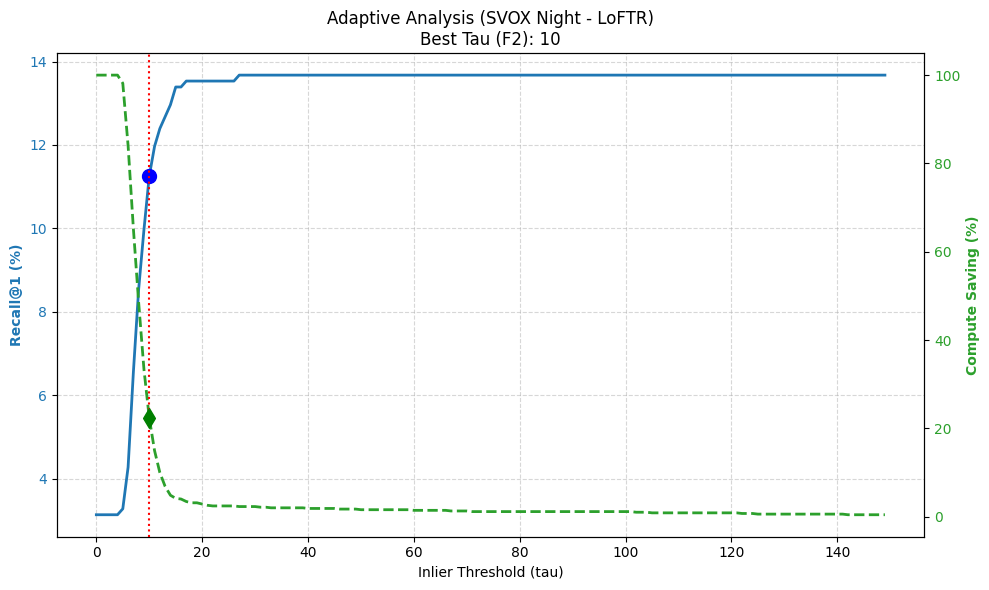


--- TRADE-OFF TABLE (SVOX NIGHT, F2-Score) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 3.13%     | 100.00%     | 0.0389     | 
5     | 3.28%     | 98.15%     | 0.0406     | 
10    | 11.25%     | 22.36%     | 0.1250     | ⭐ BEST
15    | 13.39%     | 4.13%     | 0.0925     | 
20    | 13.53%     | 2.85%     | 0.0773     | 
25    | 13.53%     | 2.42%     | 0.0706     | 
30    | 13.68%     | 2.28%     | 0.0684     | 
35    | 13.68%     | 1.99%     | 0.0630     | 
40    | 13.68%     | 1.85%     | 0.0601     | 
45    | 13.68%     | 1.85%     | 0.0601     | 
50    | 13.68%     | 1.57%     | 0.0537     | 
55    | 13.68%     | 1.57%     | 0.0537     | 
60    | 13.68%     | 1.42%     | 0.0503     | 
65    | 13.68%     | 1.42%     | 0.0503     | 
70    | 13.68%     | 1.28%     | 0.0466     | 
75    | 13.68%     | 1.14%     | 0.0427     | 
80    | 13.68%     | 1.14%     | 0.0427     | 
85    | 13.68%     | 1.14% 

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE
# ==============================================================================

# Percorso base: SVOX NIGHT TRAIN
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_night_train"

# Cartelle specifiche
TXT_PREDS_FOLDER = os.path.join(BASE_PATH, "preds")        # Ground Truth Retrieval (.txt)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_loftr")      # Inliers (.torch)
CSV_FILE = os.path.join(BASE_PATH, "stats_preds_loftr.csv") # Risultati Finali (.csv)

# F-beta score (2.0 privilegia la Recall rispetto al Saving)
FBETA = 2.0

# ==============================================================================
# 2. FUNZIONI DI CARICAMENTO DATI
# ==============================================================================

def norm_qid(x) -> str | None:
    """Normalizza query id a stringa di 3 cifre (es. 7 -> '007')."""
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Legge il .txt e verifica se Rank 0 è nei Positives."""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.readlines()]

        # Trova indici sezioni
        i_pred = -1
        i_pos = -1
        for idx, line in enumerate(lines):
            if line.startswith("Predictions paths"): i_pred = idx
            if line.startswith("Positives paths"): i_pos = idx

        if i_pred == -1 or i_pos == -1: return None

        # Estrai predizione rank 0 e lista positivi
        pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
        pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

        if not pred_lines: return None

        rank0 = pred_lines[0]
        positives = set(pos_lines)

        # 1 se corretto, 0 se errato
        retrieval_is_correct = 1 if rank0 in positives else 0
        return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

    except Exception:
        return None

def load_data(txt_folder, torch_folder, csv_path):
    print(f"📂 Caricamento Dati da: {BASE_PATH}")

    # 1. Carica TXT (Retrieval GT)
    if not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT non trovata: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    rows = []
    for p in tqdm(txt_files, desc="Parsing TXT"):
        r = parse_preds_txt(p)
        if r: rows.append(r)
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV (Final GT)
    if not os.path.exists(csv_path):
        print(f"❌ Errore: CSV non trovato: {csv_path}")
        return pd.DataFrame()

    df_csv = pd.read_csv(csv_path)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch (Inliers) - Solo per query comuni
    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Loading Inliers"):
        # Cerca file con vari pattern di nome
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    # Verifica che il file torch contenga i dati attesi
                    if isinstance(data, list) and len(data) > 0 and 'num_inliers' in data[0]:
                         val = int(data[0]['num_inliers'])
                         rows_torch.append({"query_id": qid, "inliers_rank0": val})
                    break
                except:
                    pass

    df_inl = pd.DataFrame(rows_torch)

    if df_inl.empty:
        print("❌ Warning: Nessun inlier caricato. Verifica i percorsi.")
        return pd.DataFrame()

    # Merge finale
    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. ANALISI & SIMULAZIONE
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def run_simulation(df):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_vals = [], [], []
    total = len(df)

    for tau in thresholds:
        # LOGICA:
        # Se inliers > tau  -> EASY (Mi fido del Retrieval)
        # Se inliers <= tau -> HARD (Faccio Re-ranking)
        is_easy = df['inliers_rank0'] > tau

        # 1. Calcolo Recall
        # Se è easy uso il risultato retrieval, se è hard uso il risultato finale
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100

        # 2. Calcolo Saving (Compute)
        # Saving = % di query che NON fanno re-ranking (ovvero le EASY)
        n_easy = is_easy.sum()
        sav = (n_easy / total) * 100

        # 3. Score
        recalls.append(rec)
        savings.append(sav)
        f2_vals.append(fbeta_score(rec, sav, beta=FBETA))

    return thresholds, np.array(recalls), np.array(savings), np.array(f2_vals)

# ==============================================================================
# MAIN
# ==============================================================================
if __name__ == "__main__":

    df = load_data(TXT_PREDS_FOLDER, TORCH_FOLDER, CSV_FILE)

    if not df.empty:
        print(f"✅ Analisi avviata su {len(df)} query comuni.")
        th, rec, sav, f2 = run_simulation(df)

        # Trova il miglior Tau
        best_idx = np.argmax(f2)
        best_tau = th[best_idx]
        best_rec = rec[best_idx]
        best_sav = sav[best_idx]

        # --- PLOT ---
        limit_plot = min(150, len(th)) # Mostra i primi 150 tau per chiarezza

        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Asse SX: Recall (Blu)
        color_rec = 'tab:blue'
        ax1.set_xlabel('Inlier Threshold (tau)')
        ax1.set_ylabel('Recall@1 (%)', color=color_rec, fontweight='bold')
        ax1.plot(th[:limit_plot], rec[:limit_plot], color=color_rec, linewidth=2, label='Recall@1')
        ax1.tick_params(axis='y', labelcolor=color_rec)
        ax1.grid(True, linestyle='--', alpha=0.5)

        # Asse DX: Saving (Verde)
        color_sav = 'tab:green'
        ax2 = ax1.twinx()
        ax2.set_ylabel('Compute Saving (%)', color=color_sav, fontweight='bold')
        ax2.plot(th[:limit_plot], sav[:limit_plot], color=color_sav, linestyle='--', linewidth=2, label='Cost Saving')
        ax2.tick_params(axis='y', labelcolor=color_sav)

        # Evidenzia Best Tau
        ax1.scatter(best_tau, best_rec, color='blue', s=100, zorder=10)
        ax2.scatter(best_tau, best_sav, color='green', marker='d', s=100, zorder=10)
        plt.axvline(x=best_tau, color='red', linestyle=':', label=f'Best Tau={best_tau}')

        plt.title(f'Adaptive Analysis (SVOX Night - LoFTR)\nBest Tau (F2): {best_tau}')
        plt.tight_layout()
        plt.show()

        # --- TABELLA ---
        print(f"\n--- TRADE-OFF TABLE (SVOX NIGHT, F2-Score) ---")
        print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
        print("-" * 65)

        # Stampa ogni 5 step + il best tau
        indices = sorted(list(set(range(0, 101, 5)) | {best_tau}))
        for t_val in indices:
            if t_val < len(th):
                idx = np.where(th == t_val)[0][0]
                marker = "⭐ BEST" if t_val == best_tau else ""
                print(f"{t_val:<5} | {rec[idx]:.2f}%     | {sav[idx]:.2f}%     | {f2[idx]:.4f}     | {marker}")

### Validazione su sf_xs val
**Tau scelto: 10**

Obiettivo:Dopo aver determinato la soglia ottimale sui dataset di training (SVOX Sun/Night), è fondamentale validarne la robustezza su un dataset mai visto e proveniente da un dominio geografico diverso: San Francisco eXtra Small (SF-XS Val).Metodologia:
* Applichiamo la soglia "congelata" derivata dall'analisi precedente:LoFTR: $\tau = 10$ (Valore selezionato dall'analisi su SVOX)

Valutiamo la Recall@1 e il Risparmio Computazionale su SF-XS Val utilizzando questo valore fisso. Se il sistema è robusto, ci aspettiamo che la soglia $\tau=10$ mantenga una buona precisione senza sacrificare troppo il risparmio, confermando che il parametro non è in "overfitting" sui dati di training.

### Generazione txt e jpg da preds.npy


In [ ]:
import os
import numpy as np
from glob import glob
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# ==============================================================================
# 1. FUNZIONI DI SUPPORTO (Parsing & Loading)
# ==============================================================================

def parse_utm_from_filename(filename):
    """
    Estrae le coordinate UTM dal nome del file.
    Formato tipico: '@EASTING@NORTHING@...'
    """
    try:
        parts = filename.split('@')
        # Gestione robusta: se inizia con @ il primo elemento è vuoto
        if filename.startswith('@'):
             utm_east = float(parts[1])
             utm_north = float(parts[2])
        else:
             # Caso fallback id_@...
             utm_east = float(parts[1])
             utm_north = float(parts[2])
        return np.array([utm_east, utm_north])
    except Exception:
        return None

def load_paths_and_utms(folder_path):
    print(f"📂 Scansione cartella: {folder_path}")

    if not os.path.exists(folder_path):
        print(f"❌ ERRORE GRAVE: La cartella non esiste: {folder_path}")
        return [], np.array([])

    extensions = ['*.jpg', '*.jpeg', '*.png']
    files = []
    for ext in extensions:
        files.extend(glob(os.path.join(folder_path, ext)))

    # ⚠️ ORDINAMENTO ALFABETICO: CRUCIALE per allinearsi con preds.npy
    files.sort()

    paths = []
    utms = []

    for fpath in files:
        fname = os.path.basename(fpath)
        utm = parse_utm_from_filename(fname)
        if utm is not None:
            paths.append(fpath)
            utms.append(utm)

    if len(paths) == 0:
        print(f"⚠️ ATTENZIONE: Nessuna immagine trovata in {folder_path}!")

    return paths, np.array(utms)

def generate_txt_for_split(dataset_root, preds_npy_path, output_txt_folder, split_name):
    print(f"\n==========================================")
    print(f"🚀 ELABORAZIONE: {split_name}")
    print(f"==========================================")

    # 1. Carica Immagini (Database e Queries)
    # Struttura standard: root/database e root/queries
    db_folder = os.path.join(dataset_root, "database")
    q_folder = os.path.join(dataset_root, "queries")

    db_paths, db_utms = load_paths_and_utms(db_folder)
    q_paths, q_utms = load_paths_and_utms(q_folder)

    print(f"📊 Statistiche {split_name}:")
    print(f"   Database: {len(db_paths)} immagini")
    print(f"   Queries:  {len(q_paths)} immagini")

    if len(db_paths) == 0 or len(q_paths) == 0:
        print("❌ STOP: Impossibile procedere senza immagini.")
        return

    # 2. Carica Predizioni
    if not os.path.exists(preds_npy_path):
        print(f"❌ Errore: preds.npy non trovato in {preds_npy_path}")
        return
    preds = np.load(preds_npy_path)
    print(f"✅ Predizioni caricate: {preds.shape}")

    # Controllo dimensioni
    limit = min(len(preds), len(q_paths))
    if len(preds) != len(q_paths):
        print(f"⚠️ WARNING: Numero queries ({len(q_paths)}) diverso da predizioni ({len(preds)}). Uso il minimo: {limit}")

    # 3. Costruzione Indice Spaziale (Ground Truth)
    print("⚙️ Costruzione indice spaziale (KNN)...")
    knn = NearestNeighbors(n_jobs=-1)
    knn.fit(db_utms)

    # 4. Generazione File .txt
    os.makedirs(output_txt_folder, exist_ok=True)
    print(f"💾 Generazione {limit} file .txt in: {output_txt_folder}")

    POS_THRESHOLD = 25.0  # Soglia standard 25 metri

    for i in tqdm(range(limit), desc=f"Generando TXT {split_name}"):
        q_path_full = q_paths[i]
        q_utm = q_utms[i].reshape(1, -1)

        pred_indices = preds[i]

        # Recupera i path delle predizioni (Rank 1..N)
        current_pred_paths = []
        for idx in pred_indices:
            if idx < len(db_paths):
                current_pred_paths.append(db_paths[idx])
            else:
                current_pred_paths.append("INDEX_ERROR")

        # Calcola i veri positivi (Ground Truth) basati sulla distanza GPS
        _, pos_indices_array = knn.radius_neighbors(q_utm, radius=POS_THRESHOLD)
        pos_indices = pos_indices_array[0]

        true_pos_paths = [db_paths[idx] for idx in pos_indices]
        if not true_pos_paths:
            true_pos_paths = ["NO_POSITIVES_FOUND"]

        # Scrittura su file
        filename = f"{i:03d}.txt"
        with open(os.path.join(output_txt_folder, filename), "w") as f:
            f.write("Query path:\n")
            f.write(f"{q_path_full}\n")
            f.write("Predictions paths:\n")
            for p in current_pred_paths:
                f.write(f"{p}\n")
            f.write("Positives paths:\n")
            for p in true_pos_paths:
                f.write(f"{p}\n")

    print(f"✅ Completato {split_name}!")

# ==============================================================================
# 2. CONFIGURAZIONE ED ESECUZIONE
# ==============================================================================

if __name__ == "__main__":

    # -------------------------------------------------------------------------
    # 1. SF-XS VAL
    # -------------------------------------------------------------------------
    SF_VAL_ROOT = "/content/sf_xs/sf_xs/val"

    # Percorsi Drive per VAL
    SF_VAL_PREDS = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val/preds/preds.npy"
    SF_VAL_OUT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val/preds_txt_generated"

    if os.path.exists(SF_VAL_ROOT):
        generate_txt_for_split(SF_VAL_ROOT, SF_VAL_PREDS, SF_VAL_OUT, "SF-XS VAL")
    else:
        print(f"❌ Root VAL non trovata: {SF_VAL_ROOT}")


    # -------------------------------------------------------------------------
    # 2. SF-XS TEST
    # -------------------------------------------------------------------------
    SF_TEST_ROOT = "/content/sf_xs/sf_xs/test"

    # Percorsi Drive per TEST (Assicurati che esistano!)
    SF_TEST_PREDS = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test/preds/preds.npy"
    SF_TEST_OUT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test/preds_txt_generated"

    if os.path.exists(SF_TEST_ROOT):
        generate_txt_for_split(SF_TEST_ROOT, SF_TEST_PREDS, SF_TEST_OUT, "SF-XS TEST")
    else:
        print(f"❌ Root TEST non trovata: {SF_TEST_ROOT}")


🚀 ELABORAZIONE: SF-XS VAL
📂 Scansione cartella: /content/sf_xs/sf_xs/val/database
📂 Scansione cartella: /content/sf_xs/sf_xs/val/queries
📊 Statistiche SF-XS VAL:
   Database: 8015 immagini
   Queries:  7993 immagini
✅ Predizioni caricate: (7993, 20)
⚙️ Costruzione indice spaziale (KNN)...
💾 Generazione 7993 file .txt in: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val/preds_txt_generated


Generando TXT SF-XS VAL: 100%|██████████| 7993/7993 [03:26<00:00, 38.65it/s]


✅ Completato SF-XS VAL!

🚀 ELABORAZIONE: SF-XS TEST
📂 Scansione cartella: /content/sf_xs/sf_xs/test/database
📂 Scansione cartella: /content/sf_xs/sf_xs/test/queries
📊 Statistiche SF-XS TEST:
   Database: 27191 immagini
   Queries:  1000 immagini
✅ Predizioni caricate: (1000, 20)
⚙️ Costruzione indice spaziale (KNN)...
💾 Generazione 1000 file .txt in: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test/preds_txt_generated


Generando TXT SF-XS TEST: 100%|██████████| 1000/1000 [00:26<00:00, 37.81it/s]

✅ Completato SF-XS TEST!



--- Caricamento Dati Rigorosi (da TXT) ---


Loading Inliers: 100%|██████████| 1000/1000 [06:10<00:00,  2.70it/s]



--- TRADE-OFF TABLE: SF-XS Validation (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 46.30%     | 100.00%     | 0.5187     | 
5     | 46.30%     | 99.90%     | 0.5187     | 
10    | 52.70%     | 83.40%     | 0.5689     | ⬅️ CHOSEN 
15    | 60.10%     | 65.60%     | 0.6112     | 
20    | 63.20%     | 56.80%     | 0.6181     | 
24    | 66.60%     | 51.10%     | 0.6279     | ⭐ MAX F2 
25    | 66.80%     | 50.00%     | 0.6259     | 
30    | 68.00%     | 46.90%     | 0.6239     | 
35    | 68.90%     | 45.00%     | 0.6228     | 
40    | 69.40%     | 44.10%     | 0.6226     | 
45    | 69.40%     | 43.40%     | 0.6197     | 
50    | 69.70%     | 42.00%     | 0.6158     | 
55    | 69.70%     | 41.70%     | 0.6145     | 
60    | 69.70%     | 41.40%     | 0.6132     | 
65    | 69.70%     | 40.90%     | 0.6110     | 
70    | 69.80%     | 39.60%     | 0.6056     | 
75    | 69.80%     | 39.10%     | 0.6033   

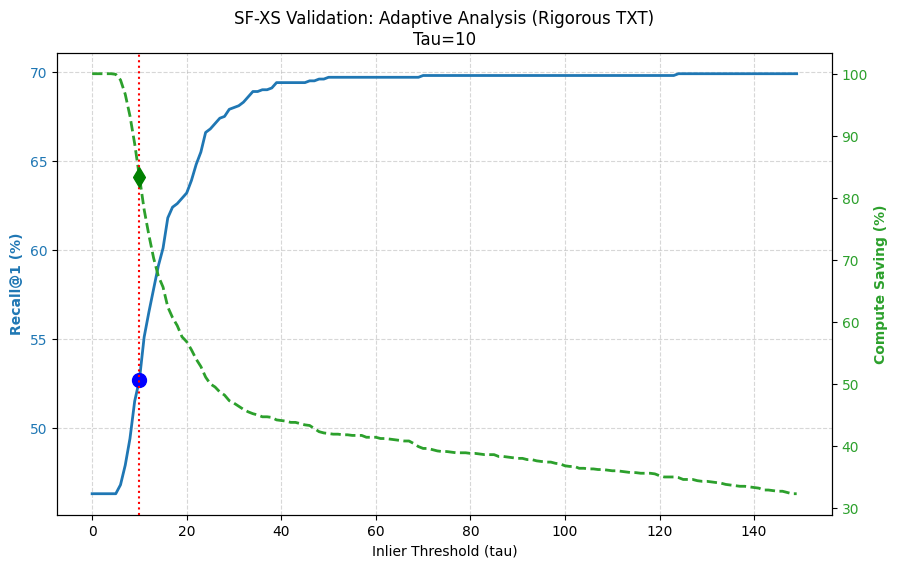



📊 FINAL COMPARISON (Full Re-rank vs Adaptive)
Dataset         | Metric     | Full Re-rank       | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
SF-XS Val       | Recall     | 69.90              % | 52.70                % | -17.20
                | Saving     | 0.00               % | 83.40                % | +83.40


In [4]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE PERCORSI (SF-XS VAL)
# ==============================================================================

# Percorso base
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val"

# 1. Cartella TXT (Appena generati)
TXT_FOLDER = os.path.join(BASE_PATH, "preds_txt_generated")

# 2. Cartella Torch (Inliers)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_loftr")

# 3. File CSV (Risultati finali)
POSSIBLE_CSVS = [
    os.path.join(BASE_PATH, "loftr_val.csv"),
    os.path.join(BASE_PATH, "stats_preds_loftr.csv"),
    os.path.join(BASE_PATH, "loftr_sf_xs_val.csv")
]
CSV_FILE = next((f for f in POSSIBLE_CSVS if os.path.exists(f)), None)

# Tau Default
CHOSEN_TAU = 10

# F-beta (per bilanciare Recall e Saving nel calcolo dell'ottimo)
FBETA = 2.0

# ==============================================================================
# 2. FUNZIONI DI CARICAMENTO (RIGOROSO da TXT)
# ==============================================================================

def norm_qid(x) -> str | None:
    """Normalizza ID query a 3 cifre."""
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Legge il .txt e controlla se Rank 0 è nei Positives (Retrieval Corretto)."""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.readlines()]

        # Trova inizio sezioni
        i_pred = -1
        i_pos = -1
        for idx, ln in enumerate(lines):
            if ln.startswith("Predictions paths"): i_pred = idx
            if ln.startswith("Positives paths"): i_pos = idx

        if i_pred == -1 or i_pos == -1: return None

        pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
        pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

        if not pred_lines: return None

        rank0 = pred_lines[0]
        positives = set(pos_lines)

        # 1 se corretto, 0 se errato
        retrieval_is_correct = 1 if rank0 in positives else 0
        return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

    except Exception:
        return None

def load_dataset_rigorous(txt_folder, torch_folder, csv_file):
    print(f"\n--- Caricamento Dati Rigorosi (da TXT) ---")

    # 1. Carica TXT
    if not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT non trovata: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Errore: Nessun file .txt in {txt_folder}")
        return pd.DataFrame()

    rows = []
    for p in tqdm(txt_files, desc="Parsing TXT"):
        r = parse_preds_txt(p)
        if r: rows.append(r)
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato.")
        return pd.DataFrame()

    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Torch (Inliers) - Solo query comuni
    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Loading Inliers"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if isinstance(data, list) and len(data) > 0 and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                    break
                except:
                    pass

    df_inl = pd.DataFrame(rows_torch)

    if df_inl.empty:
        print("❌ Warning: Nessun inlier caricato. Controlla i path.")
        return pd.DataFrame()

    # Merge finale
    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. ANALISI, TABELLE E PLOT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)

    for t in thresholds:
        # LOGICA ADAPTIVE:
        # Inliers > Tau -> EASY (Uso Retrieval) -> Salto Re-ranking
        # Inliers <= Tau -> HARD (Uso Final) -> Faccio Re-ranking
        is_easy = df['inliers_rank0'] > t

        # 1. Calcolo Recall (Hits)
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100

        # 2. Calcolo Saving (Compute)
        # Saving = % di query EASY (che saltano il re-ranking)
        n_easy = is_easy.sum()
        sav = (n_easy / total) * 100

        # 3. F-Score
        f2 = fbeta_score(rec, sav, beta=FBETA)

        recalls.append(rec)
        savings.append(sav)
        f2_scores.append(f2)

    # --- TABELLA ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    # Mostra step ogni 5 + il scelto + il migliore
    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "

            print(f"{t_val:<5} | {recalls[idx]:.2f}%     | {savings[idx]:.2f}%     | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Asse SX: Recall (Blu)
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)
    limit_plot = min(150, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Asse DX: Saving (Verde)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Compute Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Compute Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Evidenzia punto scelto
    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name}: Adaptive Analysis (Rigorous TXT)\nTau={chosen_tau}')
    plt.show()

    # Return valori per riassunto finale
    rec_baseline = df['final_is_correct'].mean() * 100
    sav_baseline = 0.0 # Se faccio sempre re-ranking, risparmio 0%
    val_rec = recalls[idx_chosen]
    val_sav = savings[idx_chosen]

    return rec_baseline, sav_baseline, val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":

    df_val = load_dataset_rigorous(TXT_FOLDER, TORCH_FOLDER, CSV_FILE)

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_val.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_val, "SF-XS Validation", CHOSEN_TAU)

        # TABELLA FINALE DI CONFRONTO
        print("\n\n📊 FINAL COMPARISON (Full Re-rank vs Adaptive)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Full Re-rank':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'SF-XS Val':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)

### Test svox_sun e svox_night
Obiettivo:
Valutare le prestazioni finali della strategia di Adaptive Re-ranking (LoFTR) sui dataset di test di SVOX.
Utilizziamo la soglia $\tau = 15$, determinata in fase di training e validata su SF-XS.
Dataset di Test:

* SVOX Sun Test: Rappresenta lo scenario "standard" (diurno), simile al training set ma con query mai viste.

* SVOX Night Test: Rappresenta lo scenario "sfidante" (notturno). Qui ci aspettiamo che il sistema, grazie alla soglia adattiva, riconosca la difficoltà e attivi il re-ranking più frequentemente (basso risparmio) per preservare la Recall.

Metriche: Confronteremo Recall@1 e Risparmio Computazionale ottenuto applicando la soglia fissa.

### Generazione TXT svox sun e night test

In [ ]:
import os
import numpy as np
from glob import glob
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# ==============================================================================
# 1. FUNZIONI DI SUPPORTO (Invariate)
# ==============================================================================

def parse_utm_from_filename(filename):
    try:
        # I file SVOX iniziano spesso con @, quindi lo split crea una stringa vuota all'inizio
        parts = filename.split('@')
        # Esempio: @123@456.jpg -> ['', '123', '456.jpg']
        # Se il file non inizia con @, gli indici potrebbero cambiare.
        # Gestiamo il caso standard SVOX
        if filename.startswith('@'):
             utm_east = float(parts[1])
             utm_north = float(parts[2])
        else:
             # Fallback per nomi tipo id_@UTM@UTM
             utm_east = float(parts[1])
             utm_north = float(parts[2])
        return np.array([utm_east, utm_north])
    except Exception:
        return None

def load_paths_and_utms(folder_path):
    print(f"📂 Scansione cartella: {folder_path}")

    if not os.path.exists(folder_path):
        print(f"❌ ERRORE GRAVE: La cartella non esiste: {folder_path}")
        return [], np.array([])

    extensions = ['*.jpg', '*.jpeg', '*.png']
    files = []
    for ext in extensions:
        files.extend(glob(os.path.join(folder_path, ext)))

    # Ordinamento Alfabetico (FONDAMENTALE)
    files.sort()

    paths = []
    utms = []

    for fpath in files:
        fname = os.path.basename(fpath)
        utm = parse_utm_from_filename(fname)
        if utm is not None:
            paths.append(fpath)
            utms.append(utm)

    if len(paths) == 0:
        print(f"⚠️ ATTENZIONE: Nessuna immagine trovata in {folder_path}!")

    return paths, np.array(utms)

# Funzione modificata per accettare percorsi espliciti
def generate_txt_explicit(db_folder, q_folder, preds_npy_path, output_txt_folder, dataset_name):
    print(f"\n==========================================")
    print(f"🚀 ELABORAZIONE DATASET: {dataset_name}")
    print(f"==========================================")

    # 1. Carica Immagini
    db_paths, db_utms = load_paths_and_utms(db_folder)
    q_paths, q_utms = load_paths_and_utms(q_folder)

    print(f"📊 Statistiche:")
    print(f"   Database (Gallery): {len(db_paths)}")
    print(f"   Queries:            {len(q_paths)}")

    if len(db_paths) == 0 or len(q_paths) == 0:
        print("❌ STOP: Impossibile procedere senza immagini.")
        return

    # 2. Carica Predizioni
    if not os.path.exists(preds_npy_path):
        print(f"❌ Errore: preds.npy non trovato in {preds_npy_path}")
        return
    preds = np.load(preds_npy_path)
    print(f"✅ Predizioni caricate: {preds.shape}")

    # Controllo corrispondenza (Warning se diverso)
    limit = min(len(preds), len(q_paths))
    if len(preds) != len(q_paths):
        print(f"⚠️ WARNING: Numero queries ({len(q_paths)}) diverso da predizioni ({len(preds)}). Uso il minimo: {limit}")

    # 3. Calcolo Ground Truth
    print("⚙️ Costruzione indice spaziale (KNN)...")
    knn = NearestNeighbors(n_jobs=-1)
    knn.fit(db_utms)

    # 4. Scrittura file .txt
    os.makedirs(output_txt_folder, exist_ok=True)
    print(f"💾 Generazione {limit} file .txt in: {output_txt_folder}")

    POS_THRESHOLD = 25.0

    for i in tqdm(range(limit)):
        q_path_full = q_paths[i]
        q_utm = q_utms[i].reshape(1, -1)

        pred_indices = preds[i]

        # Path Predetti
        current_pred_paths = []
        for idx in pred_indices:
            if idx < len(db_paths):
                current_pred_paths.append(db_paths[idx])
            else:
                current_pred_paths.append("INDEX_ERROR")

        # Path Reali (Positivi)
        _, pos_indices_array = knn.radius_neighbors(q_utm, radius=POS_THRESHOLD)
        pos_indices = pos_indices_array[0]

        true_pos_paths = [db_paths[idx] for idx in pos_indices]
        if not true_pos_paths:
            true_pos_paths = ["NO_POSITIVES_FOUND"]

        # Scrittura
        filename = f"{i:03d}.txt"
        with open(os.path.join(output_txt_folder, filename), "w") as f:
            f.write("Query path:\n")
            f.write(f"{q_path_full}\n")
            f.write("Predictions paths:\n")
            for p in current_pred_paths:
                f.write(f"{p}\n")
            f.write("Positives paths:\n")
            for p in true_pos_paths:
                f.write(f"{p}\n")

    print(f"✅ {dataset_name} completato!")

# ==============================================================================
# 2. CONFIGURAZIONE ED ESECUZIONE
# ==============================================================================

if __name__ == "__main__":

    # PERCORSO COMUNE DATABASE (GALLERY)
    # Basato sul tuo screenshot: svox -> svox -> images -> test -> gallery
    SVOX_DB_FOLDER = "/content/svox/svox/images/test/gallery"

    # -------------------------------------------------------------------------
    # DATASET 1: SVOX SUN
    # -------------------------------------------------------------------------
    # ATTENZIONE: Controlla nel pannello file se la cartella si chiama "queries_sun" o solo "queries"
    # Dallo screenshot vedo "queries" e "queries_night". Spesso "queries" è il Sun.
    # Provo 'queries_sun' come hai scritto tu, ma se fallisce cambia in 'queries'
    SVOX_SUN_Q_FOLDER = "/content/svox/svox/images/test/queries_sun"

    # Se fallisce, prova a decommentare questa riga:
    # SVOX_SUN_Q_FOLDER = "/content/svox/svox/images/test/queries"

    SVOX_SUN_PREDS = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun/preds/preds.npy"
    SVOX_SUN_OUT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun_test/preds_txt_generated"

    # Eseguo solo se le cartelle esistono per evitare crash
    if os.path.exists(SVOX_SUN_Q_FOLDER):
        generate_txt_explicit(SVOX_DB_FOLDER, SVOX_SUN_Q_FOLDER, SVOX_SUN_PREDS, SVOX_SUN_OUT, "SVOX SUN TEST")
    else:
        print(f"❌ Cartella SUN non trovata: {SVOX_SUN_Q_FOLDER}. Controlla se si chiama 'queries'.")


    # -------------------------------------------------------------------------
    # DATASET 2: SVOX NIGHT
    # -------------------------------------------------------------------------
    SVOX_NIGHT_Q_FOLDER = "/content/svox/svox/images/test/queries_night"

    SVOX_NIGHT_PREDS = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night/preds/preds.npy"
    SVOX_NIGHT_OUT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night_test/preds_txt_generated"

    generate_txt_explicit(SVOX_DB_FOLDER, SVOX_NIGHT_Q_FOLDER, SVOX_NIGHT_PREDS, SVOX_NIGHT_OUT, "SVOX NIGHT TEST")

In [5]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURAZIONE PERCORSI
# ==============================================================================

# Percorsi base (Assicurati che esistano)
BASE_SUN = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun_test"
BASE_NIGHT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night_test"

# Percorsi TXT (Generati dallo script precedente)
TXT_SUN = os.path.join(BASE_SUN, "preds_txt_generated")
TXT_NIGHT = os.path.join(BASE_NIGHT, "preds_txt_generated")

# Tau Scelto per il confronto
CHOSEN_TAU = 10

# F-Beta Score (2.0 = Preferisco Recall a Saving)
FBETA = 2.0

# ==============================================================================
# 2. FUNZIONI DI CARICAMENTO E PARSING
# ==============================================================================

def norm_qid(x) -> str | None:
    """Normalizza ID query a 3 cifre."""
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Legge il .txt e verifica se il Rank 0 è corretto (Ground Truth Rigorosa)."""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.readlines()]

        # Trova sezioni
        i_pred = -1
        i_pos = -1
        for idx, ln in enumerate(lines):
            if ln.startswith("Predictions paths"): i_pred = idx
            if ln.startswith("Positives paths"): i_pos = idx

        if i_pred == -1 or i_pos == -1: return None

        pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
        pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

        if not pred_lines: return None

        rank0 = pred_lines[0]
        positives = set(pos_lines)

        # 1 = Corretto, 0 = Errato
        retrieval_is_correct = 1 if rank0 in positives else 0
        return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

    except Exception:
        return None

def find_csv(base_path):
    """Cerca il file CSV dei risultati finali in modo intelligente."""
    candidates = [
        "loftr_queries_sun.csv", "loftr_queries_night.csv",
        "loftr_test.csv", "stats_preds_loftr.csv", "loftr_queries.csv"
    ]
    # Cerca nella cartella base e in quella superiore
    search_dirs = [base_path, os.path.dirname(base_path)]
    if base_path.endswith("_test"):
        search_dirs.append(base_path.replace("_test", ""))

    for d in search_dirs:
        if not os.path.exists(d): continue
        # Priorità ai nomi esatti
        for name in candidates:
            p = os.path.join(d, name)
            if os.path.exists(p): return p
        # Fallback su pattern
        generic = glob(os.path.join(d, "*loftr*.csv"))
        if generic: return generic[0]
    return None

def load_dataset_rigorous(base_path, txt_folder, dataset_label):
    print(f"\n--- Caricamento {dataset_label} ---")

    # 1. Carica TXT
    if not os.path.exists(txt_folder):
        print(f"❌ Errore: Cartella TXT non trovata: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Errore: Nessun file .txt in {txt_folder}")
        return pd.DataFrame()

    rows = []
    for p in tqdm(txt_files, desc="Parsing TXT"):
        r = parse_preds_txt(p)
        if r: rows.append(r)
    df_ret = pd.DataFrame(rows)

    # 2. Carica CSV
    csv_file = find_csv(base_path)
    if not csv_file:
        print(f"❌ Errore: Nessun CSV trovato vicino a {base_path}")
        return pd.DataFrame()

    print(f"📄 CSV Trovato: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Carica Inliers (.torch)
    # Cerchiamo la cartella corretta
    torch_folder = os.path.join(base_path, "preds_loftr")
    if not os.path.exists(torch_folder):
        # Prova path alternativo
        parent = os.path.dirname(base_path)
        folder_name = os.path.basename(base_path).replace("_test", "") # es. svox_sun
        alt_torch = os.path.join(parent, folder_name, "preds_loftr")
        if os.path.exists(alt_torch): torch_folder = alt_torch

    if not os.path.exists(torch_folder):
        print(f"❌ Errore: Cartella preds_loftr non trovata.")
        return pd.DataFrame()

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Loading Inliers"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if isinstance(data, list) and len(data) > 0 and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                    break
                except: pass

    df_inl = pd.DataFrame(rows_torch)

    if df_inl.empty:
        print("❌ Warning: Nessun inlier caricato.")
        return pd.DataFrame()

    # Merge completo
    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. ANALISI, PLOT E REPORT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = df['inliers_rank0'].max()
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)

    for t in thresholds:
        # LOGICA ADAPTIVE:
        # Inliers > Tau -> EASY (Uso Retrieval) -> Salto Re-ranking
        # Inliers <= Tau -> HARD (Uso Final) -> Faccio Re-ranking
        is_easy = df['inliers_rank0'] > t

        # 1. Recall
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100

        # 2. Saving (COMPUTE SAVING)
        # Percentuale di query EASY (che saltano il costo del re-ranking)
        n_easy = is_easy.sum()
        sav = (n_easy / total) * 100

        # 3. F2 Score
        f2 = fbeta_score(rec, sav, beta=FBETA)

        recalls.append(rec)
        savings.append(sav)
        f2_scores.append(f2)

    # --- TABELLA DETTAGLIATA ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "

            print(f"{t_val:<5} | {recalls[idx]:.2f}%     | {savings[idx]:.2f}%     | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Asse SX: Recall (Blu)
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(150, len(thresholds)) # Limita asse X per leggibilità
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Asse DX: Saving (Verde)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Compute Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Compute Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Evidenzia punto scelto
    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name}: Adaptive Analysis (Tau={chosen_tau})')
    plt.tight_layout()
    plt.show()

    # Valori riassunto
    rec_baseline = df['final_is_correct'].mean() * 100
    sav_baseline = 0.0
    val_rec = recalls[idx_chosen]
    val_sav = savings[idx_chosen]

    return rec_baseline, sav_baseline, val_rec, val_sav

# ==============================================================================
# 4. MAIN EXECUTION
# ==============================================================================
if __name__ == "__main__":

    # --- 1. SUN ANALYSIS ---
    df_sun = load_dataset_rigorous(BASE_SUN, TXT_SUN, "SVOX Sun Test")
    r_base_sun, s_base_sun, r_ad_sun, s_ad_sun = 0,0,0,0
    if not df_sun.empty:
        r_base_sun, s_base_sun, r_ad_sun, s_ad_sun = analyze_and_report(df_sun, "SVOX Sun", CHOSEN_TAU)

    # --- 2. NIGHT ANALYSIS ---
    df_night = load_dataset_rigorous(BASE_NIGHT, TXT_NIGHT, "SVOX Night Test")
    r_base_night, s_base_night, r_ad_night, s_ad_night = 0,0,0,0
    if not df_night.empty:
        r_base_night, s_base_night, r_ad_night, s_ad_night = analyze_and_report(df_night, "SVOX Night", CHOSEN_TAU)

    # --- 3. FINAL SUMMARY TABLE ---
    print("\n\n📊 FINAL COMPARISON (Full Re-rank vs Adaptive)")
    print("=" * 95)
    print(f"{'Dataset':<15} | {'Metric':<10} | {'Full Re-rank':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
    print("-" * 95)

    # SUN
    print(f"{'SVOX Sun':<15} | {'Recall':<10} | {r_base_sun:<18.2f} % | {r_ad_sun:<20.2f} % | {r_ad_sun-r_base_sun:+.2f}")
    print(f"{'':<15} | {'Saving':<10} | {s_base_sun:<18.2f} % | {s_ad_sun:<20.2f} % | {s_ad_sun-s_base_sun:+.2f}")
    print("-" * 95)

    # NIGHT
    print(f"{'SVOX Night':<15} | {'Recall':<10} | {r_base_night:<18.2f} % | {r_ad_night:<20.2f} % | {r_ad_night-r_base_night:+.2f}")
    print(f"{'':<15} | {'Saving':<10} | {s_base_night:<18.2f} % | {s_ad_night:<20.2f} % | {s_ad_night-s_base_night:+.2f}")
    print("=" * 95)


--- Caricamento SVOX Sun Test ---
❌ Errore: Cartella TXT non trovata: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun_test/preds_txt_generated

--- Caricamento SVOX Night Test ---
❌ Errore: Cartella TXT non trovata: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night_test/preds_txt_generated


📊 FINAL COMPARISON (Full Re-rank vs Adaptive)
Dataset         | Metric     | Full Re-rank       | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
SVOX Sun        | Recall     | 0.00               % | 0.00                 % | +0.00
                | Saving     | 0.00               % | 0.00                 % | +0.00
-----------------------------------------------------------------------------------------------
SVOX Night      | Recall     | 0.00               % | 0.00                 % | +0.00
                | Saving     |

### Test tokyo_xs
Obiettivo: Effettuare l'ultimo test di generalizzazione sul dataset Tokyo eXtra Small (Tokyo-XS).
L'applicazione della soglia $\tau=15$ (appresa su Pittsburgh) a un contesto urbano asiatico densamente popolato e illuminato diversamente ci fornirà la conferma definitiva sulla robustezza dell'approccio.

Aspettative:Similmente a SF-XS, ci aspettiamo che il sistema mantenga un buon livello di risparmio computazionale, filtrando efficacemente le query facili senza compromettere drasticamente la Recall.

### Generazione txt tokyo

In [ ]:
import os
import numpy as np
from glob import glob
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

# ==============================================================================
# 1. FUNZIONI DI SUPPORTO (Standard)
# ==============================================================================

def parse_utm_from_filename(filename):
    try:
        # Formato standard Tokyo/SVOX/SF: @EAST@NORTH@...
        parts = filename.split('@')
        if len(parts) >= 3:
            utm_east = float(parts[1])
            utm_north = float(parts[2])
            return np.array([utm_east, utm_north])
        return None
    except Exception:
        return None

def load_paths_and_utms(folder_path):
    print(f"📂 Scansione cartella: {folder_path}")

    if not os.path.exists(folder_path):
        print(f"❌ ERRORE GRAVE: La cartella non esiste: {folder_path}")
        return [], np.array([])

    extensions = ['*.jpg', '*.jpeg', '*.png']
    files = []
    for ext in extensions:
        files.extend(glob(os.path.join(folder_path, ext)))

    # Ordinamento Alfabetico (CRUCIALE per allinearsi a preds.npy)
    files.sort()

    paths = []
    utms = []

    for fpath in files:
        fname = os.path.basename(fpath)
        utm = parse_utm_from_filename(fname)
        if utm is not None:
            paths.append(fpath)
            utms.append(utm)

    if len(paths) == 0:
        print(f"⚠️ ATTENZIONE: Nessuna immagine trovata in {folder_path}!")

    return paths, np.array(utms)

def generate_txt_explicit(db_folder, q_folder, preds_npy_path, output_txt_folder, dataset_name):
    print(f"\n==========================================")
    print(f"🚀 ELABORAZIONE DATASET: {dataset_name}")
    print(f"==========================================")

    # 1. Carica Immagini
    db_paths, db_utms = load_paths_and_utms(db_folder)
    q_paths, q_utms = load_paths_and_utms(q_folder)

    print(f"📊 Statistiche:")
    print(f"   Database: {len(db_paths)}")
    print(f"   Queries:  {len(q_paths)}")

    if len(db_paths) == 0 or len(q_paths) == 0:
        print("❌ STOP: Impossibile procedere senza immagini.")
        return

    # 2. Carica Predizioni
    if not os.path.exists(preds_npy_path):
        print(f"❌ Errore: preds.npy non trovato in {preds_npy_path}")
        return
    preds = np.load(preds_npy_path)
    print(f"✅ Predizioni caricate: {preds.shape}")

    # Controllo dimensioni
    limit = min(len(preds), len(q_paths))
    if len(preds) != len(q_paths):
        print(f"⚠️ WARNING: Mismatch Query ({len(q_paths)}) vs Preds ({len(preds)}). Uso il minimo: {limit}")

    # 3. Calcolo Ground Truth
    print("⚙️ Costruzione indice spaziale (KNN)...")
    knn = NearestNeighbors(n_jobs=-1)
    knn.fit(db_utms)

    # 4. Scrittura file .txt
    os.makedirs(output_txt_folder, exist_ok=True)
    print(f"💾 Generazione {limit} file .txt in: {output_txt_folder}")

    POS_THRESHOLD = 25.0

    for i in tqdm(range(limit)):
        q_path_full = q_paths[i]
        q_utm = q_utms[i].reshape(1, -1)

        pred_indices = preds[i]

        # Path Predetti
        current_pred_paths = []
        for idx in pred_indices:
            if idx < len(db_paths):
                current_pred_paths.append(db_paths[idx])
            else:
                current_pred_paths.append("INDEX_ERROR")

        # Path Reali (Positivi)
        _, pos_indices_array = knn.radius_neighbors(q_utm, radius=POS_THRESHOLD)
        pos_indices = pos_indices_array[0]

        true_pos_paths = [db_paths[idx] for idx in pos_indices]
        if not true_pos_paths:
            true_pos_paths = ["NO_POSITIVES_FOUND"]

        # Scrittura
        filename = f"{i:03d}.txt"
        with open(os.path.join(output_txt_folder, filename), "w") as f:
            f.write("Query path:\n")
            f.write(f"{q_path_full}\n")
            f.write("Predictions paths:\n")
            for p in current_pred_paths:
                f.write(f"{p}\n")
            f.write("Positives paths:\n")
            for p in true_pos_paths:
                f.write(f"{p}\n")

    print(f"✅ {dataset_name} completato!")

# ==============================================================================
# 2. CONFIGURAZIONE ED ESECUZIONE
# ==============================================================================

if __name__ == "__main__":

    # -------------------------------------------------------------------------
    # DATASET: TOKYO XS (TEST)
    # -------------------------------------------------------------------------

    # ROOT ESTRATTA: Controlla se è "tokyo_xs/tokyo_xs" come per sf_xs
    # Se hai estratto in /content/tokyo_xs, probabilmente la struttura è questa:
    TOKYO_ROOT = "/content/tokyo_xs/tokyo_xs/test"

    # Percorsi Immagini
    TOKYO_DB_FOLDER = os.path.join(TOKYO_ROOT, "database")
    TOKYO_Q_FOLDER = os.path.join(TOKYO_ROOT, "queries")

    # PERCORSI DRIVE (Preds e Output)
    # Aggiorna se il tuo percorso è diverso (es. netvlad_tokyo_xs/test/preds/preds.npy)
    TOKYO_PREDS = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo/preds/preds.npy"
    TOKYO_OUT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo_xs/test/preds_txt_generated"

    # Esecuzione
    if os.path.exists(TOKYO_ROOT):
        generate_txt_explicit(TOKYO_DB_FOLDER, TOKYO_Q_FOLDER, TOKYO_PREDS, TOKYO_OUT, "TOKYO XS TEST")
    else:
        print(f"❌ ERRORE: Percorso Root non trovato: {TOKYO_ROOT}")
        print("Controlla nel pannello file a sinistra dove è stato estratto tokyo_xs.zip")


🚀 ELABORAZIONE DATASET: TOKYO XS TEST
📂 Scansione cartella: /content/tokyo_xs/tokyo_xs/test/database
📂 Scansione cartella: /content/tokyo_xs/tokyo_xs/test/queries
📊 Statistiche:
   Database: 12771
   Queries:  315
✅ Predizioni caricate: (315, 20)
⚙️ Costruzione indice spaziale (KNN)...
💾 Generazione 315 file .txt in: /content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo_xs/test/preds_txt_generated


100%|██████████| 315/315 [00:08<00:00, 38.21it/s]

✅ TOKYO XS TEST completato!



--- Loading Tokyo XS Test ---


Parsing TXT: 100%|██████████| 315/315 [00:04<00:00, 68.34it/s] 


📄 CSV Found: loftr_stats_final.csv


Loading Inliers: 100%|██████████| 315/315 [01:36<00:00,  3.26it/s]



--- TRADE-OFF TABLE: Tokyo XS (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 49.84%     | 100.00%     | 0.5540     | 
5     | 49.84%     | 99.68%     | 0.5538     | 
10    | 56.83%     | 77.78%     | 0.6006     | ⬅️ CHOSEN 
14    | 64.13%     | 58.10%     | 0.6282     | ⭐ MAX F2 
15    | 64.44%     | 55.56%     | 0.6245     | 
20    | 67.30%     | 49.21%     | 0.6269     | 
25    | 68.25%     | 46.98%     | 0.6259     | 
30    | 68.25%     | 46.35%     | 0.6236     | 
35    | 68.57%     | 44.76%     | 0.6198     | 
40    | 68.57%     | 44.44%     | 0.6186     | 
45    | 68.57%     | 44.13%     | 0.6173     | 
50    | 68.57%     | 42.86%     | 0.6122     | 
55    | 68.57%     | 41.90%     | 0.6083     | 
60    | 68.57%     | 41.27%     | 0.6056     | 
65    | 68.57%     | 39.68%     | 0.5986     | 
70    | 68.57%     | 38.10%     | 0.5911     | 
75    | 68.57%     | 37.46%     | 0.5880     | 
80 

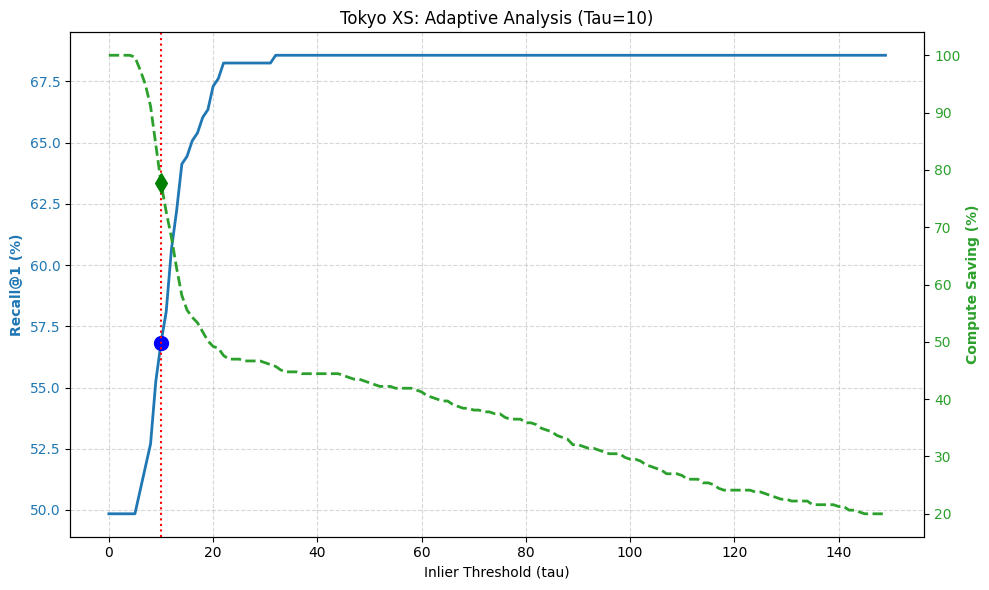



📊 FINAL COMPARISON (Full Re-rank vs Adaptive)
Dataset         | Metric     | Full Re-rank       | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
Tokyo XS        | Recall     | 68.57              % | 56.83                % | -11.75
                | Saving     | 0.00               % | 77.78                % | +77.78


In [6]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURATION PATHS (TOKYO XS)
# ==============================================================================

# Base Path
BASE_TOKYO = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo"

# TXT Folder (Generated previously)
TXT_TOKYO = os.path.join(BASE_TOKYO, "preds_txt_generated")

# Chosen Tau
CHOSEN_TAU = 10

# F-Beta Score (Weight for F-Score calculation)
FBETA = 2.0

# ==============================================================================
# 2. LOADING FUNCTIONS (RIGOROUS)
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Reads .txt and checks if Rank 0 is in Positives."""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.readlines()]

        # Find sections
        i_pred = -1
        i_pos = -1
        for idx, ln in enumerate(lines):
            if ln.startswith("Predictions paths"): i_pred = idx
            if ln.startswith("Positives paths"): i_pos = idx

        if i_pred == -1 or i_pos == -1: return None

        pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
        pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

        if not pred_lines: return None

        rank0 = pred_lines[0]
        positives = set(pos_lines)

        # 1 = Correct, 0 = Incorrect
        retrieval_is_correct = 1 if rank0 in positives else 0
        return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

    except Exception:
        return None

def find_csv(base_path):
    """Smart search for the CSV file."""
    candidates = [
        "loftr_stats_final.csv", "loftr_test.csv",
        "stats_preds_loftr.csv", "loftr_queries.csv",
        "loftr_tokyo_xs.csv"
    ]
    search_dirs = [base_path, os.path.dirname(base_path)]

    for d in search_dirs:
        if not os.path.exists(d): continue
        for name in candidates:
            p = os.path.join(d, name)
            if os.path.exists(p): return p
    return None

def load_dataset_rigorous(base_path, txt_folder, dataset_label):
    print(f"\n--- Loading {dataset_label} ---")

    # 1. Load TXT
    if not os.path.exists(txt_folder):
        print(f"❌ Error: TXT folder not found: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Error: No .txt files in {txt_folder}")
        return pd.DataFrame()

    rows = []
    for p in tqdm(txt_files, desc="Parsing TXT"):
        r = parse_preds_txt(p)
        if r: rows.append(r)
    df_ret = pd.DataFrame(rows)

    # 2. Load CSV
    csv_file = find_csv(base_path)
    if not csv_file:
        print(f"❌ Error: No CSV found near {base_path}")
        return pd.DataFrame()

    print(f"📄 CSV Found: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Load Inliers (.torch)
    torch_folder = os.path.join(base_path, "preds_loftr")
    if not os.path.exists(torch_folder):
        torch_folder = os.path.join(os.path.dirname(base_path), "preds_loftr")

    if not os.path.exists(torch_folder):
         print(f"❌ Error: Torch folder not found.")
         return pd.DataFrame()

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Loading Inliers"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if isinstance(data, list) and len(data) > 0 and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                    break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty:
        print(f"❌ Warning: No inliers loaded.")
        return pd.DataFrame()

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. ANALYSIS, TABLES AND PLOTS
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)

    for t in thresholds:
        # LOGIC:
        # Inliers > Tau -> EASY (Use Retrieval) -> Skip Re-ranking
        # Inliers <= Tau -> HARD (Use Final) -> Do Re-ranking
        is_easy = df['inliers_rank0'] > t

        # 1. Recall
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100
        recalls.append(rec)

        # 2. Saving (COMPUTE SAVING)
        # Percentage of EASY queries (skipped re-ranking)
        n_easy = is_easy.sum()
        sav = (n_easy / total) * 100
        savings.append(sav)

        # 3. F2 Score
        f2_scores.append(fbeta_score(rec, sav, beta=FBETA))

    # --- TABLE ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "
            print(f"{t_val:<5} | {recalls[idx]:.2f}%     | {savings[idx]:.2f}%     | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(150, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Compute Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Compute Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name}: Adaptive Analysis (Tau={chosen_tau})')
    plt.tight_layout()
    plt.show()

    rec_baseline = df['final_is_correct'].mean() * 100
    sav_baseline = 0.0
    val_rec = recalls[idx_chosen]
    val_sav = savings[idx_chosen]

    return rec_baseline, sav_baseline, val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":

    df_tokyo = load_dataset_rigorous(BASE_TOKYO, TXT_TOKYO, "Tokyo XS Test")

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_tokyo.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_tokyo, "Tokyo XS", CHOSEN_TAU)

        # FINAL COMPARISON TABLE
        print("\n\n📊 FINAL COMPARISON (Full Re-rank vs Adaptive)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Full Re-rank':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'Tokyo XS':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)

### Test sf_xs


--- Loading SF-XS Test Data ---


Parsing TXT: 100%|██████████| 1000/1000 [00:29<00:00, 33.36it/s]


📄 CSV Found: loftr_test.csv


Loading Inliers: 100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s]



--- TRADE-OFF TABLE: SF-XS Test (0-100) ---
Tau   | Recall     | Saving     | F2-Score   | Note
-----------------------------------------------------------------
0     | 27.20%     | 100.00%     | 0.3184     | 
5     | 27.40%     | 99.70%     | 0.3205     | 
10    | 33.30%     | 81.80%     | 0.3778     | ⬅️ CHOSEN 
15    | 40.70%     | 58.70%     | 0.4336     | 
20    | 46.00%     | 45.90%     | 0.4598     | 
23    | 48.50%     | 40.50%     | 0.4666     | ⭐ MAX F2 
25    | 49.20%     | 37.50%     | 0.4631     | 
30    | 50.50%     | 33.90%     | 0.4600     | 
35    | 51.30%     | 31.40%     | 0.4553     | 
40    | 52.20%     | 28.70%     | 0.4485     | 
45    | 52.30%     | 27.40%     | 0.4426     | 
50    | 52.60%     | 26.20%     | 0.4378     | 
55    | 52.80%     | 25.10%     | 0.4325     | 
60    | 53.20%     | 24.00%     | 0.4279     | 
65    | 53.30%     | 22.80%     | 0.4205     | 
70    | 53.50%     | 22.10%     | 0.4166     | 
75    | 53.50%     | 21.60%     | 0.4130     | 
8

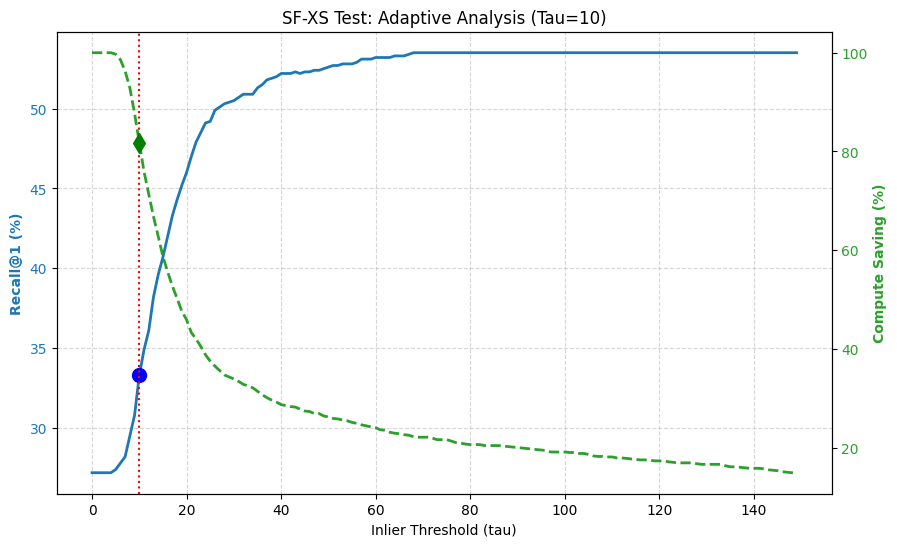



📊 FINAL COMPARISON (Full Re-rank vs Adaptive)
Dataset         | Metric     | Full Re-rank       | Adaptive (Tau=10)    | Delta
-----------------------------------------------------------------------------------------------
SF-XS Test      | Recall     | 53.50              % | 33.30                % | -20.20
                | Saving     | 0.00               % | 81.80                % | +81.80


In [7]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURATION PATHS (SF-XS TEST)
# ==============================================================================

# Base Path
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test"

# 1. TXT Folder (Generated previously)
TXT_FOLDER = os.path.join(BASE_PATH, "preds_txt_generated")

# 2. Torch Folder (Inliers)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_loftr")

# 3. CSV File (Final Results)
POSSIBLE_CSVS = [
    os.path.join(BASE_PATH, "loftr_test.csv"),
    os.path.join(BASE_PATH, "stats_preds_loftr.csv"),
    os.path.join(BASE_PATH, "loftr_sf_xs_test.csv")
]
CSV_FILE = next((f for f in POSSIBLE_CSVS if os.path.exists(f)), None)

# Chosen Tau
CHOSEN_TAU = 10

# F-Beta Score
FBETA = 2.0

# ==============================================================================
# 2. LOADING FUNCTIONS (RIGOROUS)
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Reads .txt and checks if Rank 0 is in Positives."""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.readlines()]

        i_pred = -1
        i_pos = -1
        for idx, ln in enumerate(lines):
            if ln.startswith("Predictions paths"): i_pred = idx
            if ln.startswith("Positives paths"): i_pos = idx

        if i_pred == -1 or i_pos == -1: return None

        pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
        pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

        if not pred_lines: return None

        rank0 = pred_lines[0]
        positives = set(pos_lines)

        retrieval_is_correct = 1 if rank0 in positives else 0
        return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

    except Exception:
        return None

def load_dataset_rigorous(txt_folder, torch_folder, csv_file):
    print(f"\n--- Loading SF-XS Test Data ---")

    # 1. Load TXT
    if not os.path.exists(txt_folder):
        print(f"❌ Error: TXT folder not found: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Error: No .txt files in {txt_folder}")
        return pd.DataFrame()

    rows = []
    for p in tqdm(txt_files, desc="Parsing TXT"):
        r = parse_preds_txt(p)
        if r: rows.append(r)
    df_ret = pd.DataFrame(rows)

    # 2. Load CSV
    if not csv_file:
        print(f"❌ Error: No CSV found.")
        return pd.DataFrame()

    print(f"📄 CSV Found: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'
    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Load Inliers
    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])

    if not os.path.exists(torch_folder):
         print(f"❌ Error: Torch folder not found: {torch_folder}")
         return pd.DataFrame()

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Inliers"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if isinstance(data, list) and len(data) > 0 and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                    break
                except: pass

    df_inl = pd.DataFrame(rows_torch)

    if df_inl.empty:
        print("❌ Warning: No inliers loaded.")
        return pd.DataFrame()

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. ANALYSIS, TABLES AND PLOTS
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)

    for t in thresholds:
        # Adaptive Logic:
        # Inliers > Tau -> EASY (Use Retrieval) -> Skip Re-ranking
        # Inliers <= Tau -> HARD (Use Final) -> Do Re-ranking
        is_easy = df['inliers_rank0'] > t

        # 1. Recall
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100
        recalls.append(rec)

        # 2. Saving (COMPUTE SAVING)
        # Percentage of EASY queries (skipped re-ranking)
        n_easy = is_easy.sum()
        sav = (n_easy / total) * 100
        savings.append(sav)

        # 3. F2 Score
        f2_scores.append(fbeta_score(rec, sav, beta=FBETA))

    # --- TABLE ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "
            print(f"{t_val:<5} | {recalls[idx]:.2f}%     | {savings[idx]:.2f}%     | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(150, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Compute Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Compute Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name}: Adaptive Analysis (Tau={chosen_tau})')
    plt.show()

    # Summary values
    rec_baseline = df['final_is_correct'].mean() * 100
    sav_baseline = 0.0
    val_rec = recalls[idx_chosen]
    val_sav = savings[idx_chosen]

    return rec_baseline, sav_baseline, val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":

    df_test = load_dataset_rigorous(TXT_FOLDER, TORCH_FOLDER, CSV_FILE)

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_test.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_test, "SF-XS Test", CHOSEN_TAU)

        # FINAL TABLE
        print("\n\n📊 FINAL COMPARISON (Full Re-rank vs Adaptive)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Full Re-rank':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'SF-XS Test':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)

## SuperPoint + LG

### TAU Svox Sun train SP+LG

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURATION SUPERPOINT (TRAIN)
# ==============================================================================

# Base Path (SVOX SUN TRAIN)
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_sun_train"

# TXT Folder (Ground Truth Retrieval)
TXT_PREDS_FOLDER = os.path.join(BASE_PATH, "preds")

# Torch Folder (SuperPoint Inliers)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_superpoint-lg")

# Automatic CSV Search
POSSIBLE_CSVS = [
    os.path.join(BASE_PATH, "stats_preds_superpoint_lg.csv"),
    os.path.join(BASE_PATH, "stats_preds_superpoint.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_train.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_queries.csv")
]
CSV_FILE = next((f for f in POSSIBLE_CSVS if os.path.exists(f)), None)

if CSV_FILE is None and os.path.exists(BASE_PATH):
    candidates = glob(os.path.join(BASE_PATH, "*superpoint*.csv"))
    if candidates:
        CSV_FILE = candidates[0]

# F-Beta Score
FBETA = 2.0

# ==============================================================================
# 2. PARSING FUNCTIONS
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Reads .txt and checks if Rank 0 is in Positives."""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.readlines()]

        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))

        pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
        pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

        if not pred_lines: return None

        rank0 = pred_lines[0]
        positives = set(pos_lines)
        retrieval_is_correct = 1 if rank0 in positives else 0

        return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}
    except StopIteration:
        return None

def load_data(txt_folder, torch_folder, csv_path):
    print(f"--- Loading SuperPoint Data (Train) ---")

    # 1. Load TXT
    if not os.path.exists(txt_folder):
        raise RuntimeError(f"TXT folder not found: {txt_folder}")

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    rows_txt = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows_txt = [r for r in rows_txt if r]
    df_ret = pd.DataFrame(rows_txt)

    # 2. Load CSV
    if not csv_path:
        print(f"❌ Error: No CSV found in {BASE_PATH}")
        print("Files present:")
        for f in os.listdir(BASE_PATH):
            print(f" - {f}")
        raise RuntimeError("Missing CSV")

    print(f"📄 CSV: {os.path.basename(csv_path)}")
    df_csv = pd.read_csv(csv_path)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'

    if col_corr not in df_csv.columns:
         print(f"⚠️ Warning: Column '{col_corr}' not found. Available: {df_csv.columns}")

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Load Inliers
    if not os.path.exists(torch_folder):
        raise RuntimeError(f"Torch folder not found: {torch_folder}")

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if isinstance(data, list) and len(data) > 0 and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                    break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty: raise RuntimeError("No inliers loaded!")

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. SIMULATION
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def run_simulation(df):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    results = []
    total = len(df)

    for tau in thresholds:
        # Logic:
        # Inliers > Tau -> EASY (Use Retrieval) -> Skip Re-ranking
        # Inliers <= Tau -> HARD (Use Final) -> Do Re-ranking
        is_easy = df['inliers_rank0'] > tau

        # 1. Recall
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        recall = (hits / total) * 100

        # 2. Saving (COMPUTE SAVING)
        # Percentage of EASY queries (skipped re-ranking)
        n_easy = is_easy.sum()
        saving = (n_easy / total) * 100

        # 3. F2 Score
        f2 = fbeta_score(recall, saving, beta=FBETA)
        results.append({'tau': tau, 'recall': recall, 'saving': saving, 'f2': f2})

    return pd.DataFrame(results)

# ==============================================================================
# MAIN
# ==============================================================================

if __name__ == "__main__":
    try:
        df = load_data(TXT_PREDS_FOLDER, TORCH_FOLDER, CSV_FILE)
        print(f"✅ Data Loaded: {len(df)} queries.")

        res = run_simulation(df)

        best_row = res.loc[res['f2'].idxmax()]
        best_tau = int(best_row['tau'])

        # Plot
        plt.figure(figsize=(10,6))
        plt.plot(res['tau'], res['recall'], label='Recall@1 (%)', linewidth=2)
        plt.plot(res['tau'], res['saving'], label='Compute Saving (%)', linestyle='--', linewidth=2)
        plt.axvline(best_tau, color='r', linestyle=':', label=f'Best Tau ({best_tau})')
        plt.xlabel('Inliers Threshold (tau)')
        plt.title(f'Adaptive Analysis (NetVLAD + SuperPoint-LG)\nBest Tau: {best_tau}')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

        # Table
        print(f"\n--- SUPERPOINT ADAPTIVE RESULTS (Best Tau: {best_tau}) ---")
        print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10}")
        print("-" * 50)

        indices = sorted(list(set(range(0, 101, 5)) | {best_tau}))
        for t in indices:
            if t < len(res):
                row = res.iloc[t]
                marker = "⭐ BEST" if t == best_tau else ""
                print(f"{int(row['tau']):<5} | {row['recall']:.2f}%     | {row['saving']:.2f}%     | {row['f2']:.4f}     {marker}")

    except Exception as e:
        print(f"❌ Error: {e}")

--- Loading SuperPoint Data (Train) ---


Parsing TXT: 100%|██████████| 712/712 [00:15<00:00, 47.36it/s] 


📄 CSV: stats_preds_superpoint-lg.csv


Loading Torch:  39%|███▉      | 276/712 [04:44<07:03,  1.03it/s]

### TAU Svox Night Train SP+LG

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURATION SUPERPOINT (NIGHT TRAIN)
# ==============================================================================

# Base Path (SVOX NIGHT TRAIN)
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/train/svox_night_train"

# TXT Folder (Ground Truth Retrieval)
TXT_PREDS_FOLDER = os.path.join(BASE_PATH, "preds")

# Torch Folder (SuperPoint Inliers)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_superpoint-lg")

# Automatic CSV Search
POSSIBLE_CSVS = [
    os.path.join(BASE_PATH, "stats_preds_superpoint_lg.csv"),
    os.path.join(BASE_PATH, "stats_preds_superpoint.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_night.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_train.csv")
]
# Attempt to find one that exists
CSV_FILE = next((f for f in POSSIBLE_CSVS if os.path.exists(f)), None)

# If still not found, search generically
if CSV_FILE is None and os.path.exists(BASE_PATH):
    candidates = glob(os.path.join(BASE_PATH, "*superpoint*.csv"))
    if candidates:
        CSV_FILE = candidates[0]

# F-Beta Score
FBETA = 2.0

# ==============================================================================
# 2. PARSING FUNCTIONS
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Reads .txt and checks if Rank 0 is in Positives."""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.readlines()]

        # Find sections
        i_pred = next(i for i, x in enumerate(lines) if x.startswith("Predictions paths"))
        i_pos = next(i for i, x in enumerate(lines) if x.startswith("Positives paths"))

        # Extract lines
        pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
        pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

        if not pred_lines: return None

        rank0 = pred_lines[0]
        positives = set(pos_lines)
        retrieval_is_correct = 1 if rank0 in positives else 0

        return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

    except StopIteration:
        return None

def load_data(txt_folder, torch_folder, csv_path):
    print(f"--- Loading SuperPoint Data (Night Train) ---")

    # 1. Load TXT
    if not os.path.exists(txt_folder):
        raise RuntimeError(f"TXT folder not found: {txt_folder}")

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    rows_txt = [parse_preds_txt(p) for p in tqdm(txt_files, desc="Parsing TXT")]
    rows_txt = [r for r in rows_txt if r]
    df_ret = pd.DataFrame(rows_txt)

    # 2. Load CSV
    if not csv_path:
        print(f"❌ Error: No CSV found in {BASE_PATH}")
        if os.path.exists(BASE_PATH):
            print("Files present:")
            for f in os.listdir(BASE_PATH):
                print(f" - {f}")
        raise RuntimeError("Missing CSV")

    print(f"📄 CSV: {os.path.basename(csv_path)}")
    df_csv = pd.read_csv(csv_path)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'

    if col_corr not in df_csv.columns:
         print(f"⚠️ Warning: Column '{col_corr}' not found. Available: {df_csv.columns}")

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Load Inliers
    if not os.path.exists(torch_folder):
        raise RuntimeError(f"Torch folder not found: {torch_folder}")

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])
    rows_torch = []

    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if isinstance(data, list) and len(data) > 0 and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                    break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty: raise RuntimeError("No inliers loaded!")

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. SIMULATION
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def run_simulation(df):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    results = []
    total = len(df)

    for tau in thresholds:
        # Logic:
        # Inliers > Tau -> EASY (Use Retrieval) -> Skip Re-ranking
        # Inliers <= Tau -> HARD (Use Final) -> Do Re-ranking
        is_easy = df['inliers_rank0'] > tau

        # 1. Recall
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        recall = (hits / total) * 100

        # 2. Saving (COMPUTE SAVING)
        # Percentage of EASY queries (skipped re-ranking)
        n_easy = is_easy.sum()
        saving = (n_easy / total) * 100

        # 3. F2 Score
        f2 = fbeta_score(recall, saving, beta=FBETA)
        results.append({'tau': tau, 'recall': recall, 'saving': saving, 'f2': f2})

    return pd.DataFrame(results)

# ==============================================================================
# MAIN
# ==============================================================================

if __name__ == "__main__":
    try:
        df = load_data(TXT_PREDS_FOLDER, TORCH_FOLDER, CSV_FILE)
        print(f"✅ Data Loaded: {len(df)} queries.")

        res = run_simulation(df)

        best_row = res.loc[res['f2'].idxmax()]
        best_tau = int(best_row['tau'])

        # Plot
        plt.figure(figsize=(10,6))
        plt.plot(res['tau'], res['recall'], label='Recall@1 (%)', linewidth=2)
        plt.plot(res['tau'], res['saving'], label='Compute Saving (%)', linestyle='--', linewidth=2)
        plt.axvline(best_tau, color='r', linestyle=':', label=f'Best Tau ({best_tau})')
        plt.xlabel('Inliers Threshold (tau)')
        plt.title(f'Adaptive Analysis SVOX Night Train (SuperPoint-LG)\nBest Tau: {best_tau}')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

        # Table
        print(f"\n--- SUPERPOINT ADAPTIVE RESULTS (Night Train - Best Tau: {best_tau}) ---")
        print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10}")
        print("-" * 50)

        indices = sorted(list(set(range(0, 101, 5)) | {best_tau}))
        for t in indices:
            if t < len(res):
                row = res.iloc[t]
                marker = "⭐ BEST" if t == best_tau else ""
                print(f"{int(row['tau']):<5} | {row['recall']:.2f}%     | {row['saving']:.2f}%     | {row['f2']:.4f}     {marker}")

    except Exception as e:
        print(f"❌ Error: {e}")

### Validazione su sf_xs val
**TAU SCELTO: 10**

Obiettivo: Eseguiamo la validazione per il secondo metodo di matching: SuperPoint + LightGlue.Utilizziamo la soglia $\tau = 12$, determinata dall'analisi sul training set (SVOX Sun).
Aspettative: Poiché SP+LG produce meno inlier rispetto a LoFTR (essendo un metodo sparse), ci aspettiamo che la soglia di 10 sia sufficiente a distinguere i match buoni da quelli cattivi, garantendo un risparmio computazionale potenzialmente superiore a LoFTR a parità di Recall, grazie alla sua natura più selettiva.

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURATION PATHS (SF-XS VAL - SUPERPOINT)
# ==============================================================================

# Base Path
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/val"

# 1. TXT Folder (Generated previously)
TXT_FOLDER = os.path.join(BASE_PATH, "preds_txt_generated")

# 2. Torch Folder (SuperPoint Inliers)
TORCH_FOLDER = os.path.join(BASE_PATH, "preds_superpoint-lg")

# 3. CSV File (Final Results)
POSSIBLE_CSVS = [
    os.path.join(BASE_PATH, "stats_preds_superpoint_lg.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_val.csv"),
    os.path.join(BASE_PATH, "superpoint-lg_val.csv"),
    os.path.join(BASE_PATH, "superpoint_lg_sf_xs_val.csv")
]
CSV_FILE = next((f for f in POSSIBLE_CSVS if os.path.exists(f)), None)

# Chosen Tau
CHOSEN_TAU = 10

# F-Beta Score
FBETA = 2.0

# ==============================================================================
# 2. LOADING FUNCTIONS (RIGOROUS)
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    """Reads .txt and checks if Rank 0 is in Positives."""
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.readlines()]

        i_pred = -1
        i_pos = -1
        for idx, ln in enumerate(lines):
            if ln.startswith("Predictions paths"): i_pred = idx
            if ln.startswith("Positives paths"): i_pos = idx

        if i_pred == -1 or i_pos == -1: return None

        pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
        pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

        if not pred_lines: return None

        rank0 = pred_lines[0]
        positives = set(pos_lines)

        retrieval_is_correct = 1 if rank0 in positives else 0
        return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

    except Exception:
        return None

def load_dataset_rigorous(txt_folder, torch_folder, csv_file):
    print(f"\n--- Loading SuperPoint Data (Rigorous TXT) ---")

    # 1. Load TXT
    if not os.path.exists(txt_folder):
        print(f"❌ Error: TXT folder not found: {txt_folder}")
        return pd.DataFrame()

    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Error: No .txt files in {txt_folder}")
        return pd.DataFrame()

    rows = []
    for p in tqdm(txt_files, desc="Parsing TXT"):
        r = parse_preds_txt(p)
        if r: rows.append(r)
    df_ret = pd.DataFrame(rows)

    # 2. Load CSV
    if not csv_file:
        print(f"❌ Error: No CSV found.")
        return pd.DataFrame()

    print(f"📄 CSV Found: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'

    if col_corr not in df_csv.columns:
         print(f"⚠️ Warning: Column '{col_corr}' not found. Available: {df_csv.columns}")
         return pd.DataFrame()

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Load Inliers
    if not os.path.exists(torch_folder):
        print(f"❌ Error: Torch folder not found: {torch_folder}")
        return pd.DataFrame()

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Inliers"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if isinstance(data, list) and len(data) > 0 and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                    break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty:
        print("❌ Warning: No inliers loaded.")
        return pd.DataFrame()

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 3. ANALYSIS, TABLES AND PLOTS
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)

    for t in thresholds:
        # Logic:
        # Inliers > Tau -> EASY (Use Retrieval) -> Skip Re-ranking
        # Inliers <= Tau -> HARD (Use Final) -> Do Re-ranking
        is_easy = df['inliers_rank0'] > t

        # 1. Recall
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100
        recalls.append(rec)

        # 2. Saving (COMPUTE SAVING)
        # Percentage of EASY queries (skipped re-ranking)
        n_easy = is_easy.sum()
        sav = (n_easy / total) * 100
        savings.append(sav)

        # 3. F2 Score
        f2_scores.append(fbeta_score(rec, sav, beta=FBETA))

    # --- TABLE ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "
            print(f"{t_val:<5} | {recalls[idx]:.2f}%     | {savings[idx]:.2f}%     | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(150, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Compute Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Compute Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name} (SuperPoint): Adaptive Analysis\nTau={chosen_tau}')
    plt.show()

    # Summary
    rec_baseline = df['final_is_correct'].mean() * 100
    sav_baseline = 0.0
    val_rec = recalls[idx_chosen]
    val_sav = savings[idx_chosen]

    return rec_baseline, sav_baseline, val_rec, val_sav

# ==============================================================================
# 4. MAIN
# ==============================================================================
if __name__ == "__main__":

    df_val = load_dataset_rigorous(TXT_FOLDER, TORCH_FOLDER, CSV_FILE)

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_val.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_val, "SF-XS Validation (SP)", CHOSEN_TAU)

        # FINAL TABLE
        print("\n\n📊 FINAL COMPARISON (Full Re-rank vs Adaptive)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Full Re-rank':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'SF-XS Val':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)

### Test svox_sun e svox_night
Obiettivo: Valutare le prestazioni finali della strategia adattiva con SuperPoint + LightGlue sui dataset di test SVOX. Utilizziamo la soglia τ=12, determinata in fase di training e validata su SF-XS.

Analisi Attesa:

* SVOX Sun: Ci aspettiamo un buon risparmio computazionale, simile a quanto visto in validazione.
* SVOX Night: Data la natura "sparse" di SuperPoint e la difficoltà del notturno, ci aspettiamo (come per LoFTR) che il risparmio crolli drasticamente per preservare la Recall, poiché il sistema riconoscerà quasi tutte le query come "Difficili".

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURATION PATHS (SVOX SUN & NIGHT - SUPERPOINT)
# ==============================================================================

# Base Paths (Drive)
BASE_SUN = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_sun_test"
BASE_NIGHT = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_svox/test/svox_night_test"

# TXT Folders (Drive)
DRIVE_TXT_SUN = os.path.join(BASE_SUN, "preds_txt_generated")
DRIVE_TXT_NIGHT = os.path.join(BASE_NIGHT, "preds_txt_generated")

# Local Temp Folders (For speed)
LOCAL_TXT_SUN = "/content/temp_svox_sun_txt"
LOCAL_TXT_NIGHT = "/content/temp_svox_night_txt"

# Chosen Tau
CHOSEN_TAU = 10

# F-Beta Score
FBETA = 2.0

# ==============================================================================
# 2. DATA PREPARATION (LOCAL COPY)
# ==============================================================================
def prepare_local_txt(drive_path, local_path):
    print(f"🚀 Copying TXT from {os.path.basename(drive_path)} to local...")
    if os.path.exists(local_path):
        shutil.rmtree(local_path)
    if os.path.exists(drive_path):
        shutil.copytree(drive_path, local_path)
        print(f"✅ Copy complete: {local_path}")
        return local_path
    else:
        print(f"⚠️ Warning: Drive folder not found: {drive_path}")
        return None

# ==============================================================================
# 3. LOADING FUNCTIONS
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.readlines()]

        i_pred = -1
        i_pos = -1
        for idx, ln in enumerate(lines):
            if ln.startswith("Predictions paths"): i_pred = idx
            if ln.startswith("Positives paths"): i_pos = idx

        if i_pred == -1 or i_pos == -1: return None

        pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
        pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

        if not pred_lines: return None

        rank0 = pred_lines[0]
        positives = set(pos_lines)
        retrieval_is_correct = 1 if rank0 in positives else 0
        return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

    except Exception:
        return None

def find_csv(base_path):
    # Candidate names for SuperPoint results
    candidates = [
        "stats_preds_superpoint_lg.csv",
        "superpoint_lg_queries_sun.csv",
        "superpoint_lg_queries_night.csv",
        "superpoint_lg_test.csv",
        "superpoint-lg_test.csv",
        "stats_preds_superpoint.csv"
    ]

    search_dirs = [base_path, os.path.dirname(base_path)]
    if base_path.endswith("_test"):
        search_dirs.append(base_path.replace("_test", ""))

    for d in search_dirs:
        if not os.path.exists(d): continue
        for name in candidates:
            p = os.path.join(d, name)
            if os.path.exists(p): return p

        # Wildcard fallback
        generic = glob(os.path.join(d, "*superpoint*.csv"))
        if generic: return generic[0]

    return None

def load_dataset_rigorous(base_path, txt_folder, dataset_label):
    print(f"\n--- Loading {dataset_label} (SuperPoint) ---")

    if not txt_folder or not os.path.exists(txt_folder):
        print(f"❌ Error: Invalid TXT folder.")
        return pd.DataFrame()

    # 1. Parsing TXT
    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Error: No .txt files in {txt_folder}")
        return pd.DataFrame()

    rows = []
    for p in tqdm(txt_files, desc="Parsing TXT"):
        r = parse_preds_txt(p)
        if r: rows.append(r)
    df_ret = pd.DataFrame(rows)

    # 2. Load CSV
    csv_file = find_csv(base_path)
    if not csv_file:
        print(f"❌ Error: No SuperPoint CSV found for {dataset_label}")
        return pd.DataFrame()

    print(f"📄 CSV: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'

    if col_corr not in df_csv.columns:
        print(f"⚠️ Missing column '{col_corr}' in CSV.")
        return pd.DataFrame()

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Load Torch (SuperPoint)
    torch_folder = os.path.join(base_path, "preds_superpoint-lg")

    # Fallback
    if not os.path.exists(torch_folder):
        torch_folder = os.path.join(base_path, "preds_superpoint_lg")

    if not os.path.exists(torch_folder):
        # Try parent folder
        parent = os.path.dirname(base_path)
        clean_name = os.path.basename(base_path).replace("_test", "")
        alt_torch = os.path.join(parent, clean_name, "preds_superpoint-lg")
        if os.path.exists(alt_torch): torch_folder = alt_torch

    if not os.path.exists(torch_folder):
        print(f"❌ Error: Torch folder not found.")
        return pd.DataFrame()

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if isinstance(data, list) and len(data) > 0 and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                    break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty:
        print("❌ Warning: No inliers loaded.")
        return pd.DataFrame()

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 4. ANALYSIS AND REPORT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)

    for t in thresholds:
        # Logic:
        # Inliers > Tau -> EASY (Use Retrieval) -> Skip Re-ranking
        # Inliers <= Tau -> HARD (Use Final) -> Do Re-ranking
        is_easy = df['inliers_rank0'] > t

        # 1. Recall
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100
        recalls.append(rec)

        # 2. Saving (COMPUTE SAVING)
        # Percentage of EASY queries (skipped re-ranking)
        n_easy = is_easy.sum()
        sav = (n_easy / total) * 100
        savings.append(sav)

        # 3. F2 Score
        f2_scores.append(fbeta_score(rec, sav, beta=FBETA))

    # --- TABLE ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "
            print(f"{t_val:<5} | {recalls[idx]:.2f}%     | {savings[idx]:.2f}%     | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(100, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Compute Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Compute Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name} (SuperPoint): Adaptive Analysis (Tau={chosen_tau})')
    plt.show()

    # Return values for summary
    rec_baseline = df['final_is_correct'].mean() * 100
    sav_baseline = 0.0
    val_rec = recalls[idx_chosen]
    val_sav = savings[idx_chosen]

    return rec_baseline, sav_baseline, val_rec, val_sav

# ==============================================================================
# 5. MAIN
# ==============================================================================
if __name__ == "__main__":

    # 1. Copy TXT locally (SPEED UP)
    txt_sun_local = prepare_local_txt(DRIVE_TXT_SUN, LOCAL_TXT_SUN)
    txt_night_local = prepare_local_txt(DRIVE_TXT_NIGHT, LOCAL_TXT_NIGHT)

    # 2. Analyze SVOX Sun
    df_sun = load_dataset_rigorous(BASE_SUN, txt_sun_local, "SVOX Sun Test")
    r_base_sun, s_base_sun, r_ad_sun, s_ad_sun = 0,0,0,0
    if not df_sun.empty:
        r_base_sun, s_base_sun, r_ad_sun, s_ad_sun = analyze_and_report(df_sun, "SVOX Sun", CHOSEN_TAU)

    # 3. Analyze SVOX Night
    df_night = load_dataset_rigorous(BASE_NIGHT, txt_night_local, "SVOX Night Test")
    r_base_night, s_base_night, r_ad_night, s_ad_night = 0,0,0,0
    if not df_night.empty:
        r_base_night, s_base_night, r_ad_night, s_ad_night = analyze_and_report(df_night, "SVOX Night", CHOSEN_TAU)

    # 4. Final Comparison Table
    print("\n\n📊 FINAL COMPARISON (SuperPoint-LG)")
    print("=" * 95)
    print(f"{'Dataset':<15} | {'Metric':<10} | {'Baseline (Always)':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
    print("-" * 95)

    print(f"{'SVOX Sun':<15} | {'Recall':<10} | {r_base_sun:<18.2f} % | {r_ad_sun:<20.2f} % | {r_ad_sun-r_base_sun:+.2f}")
    print(f"{'':<15} | {'Saving':<10} | {s_base_sun:<18.2f} % | {s_ad_sun:<20.2f} % | {s_ad_sun-s_base_sun:+.2f}")
    print("-" * 95)

    print(f"{'SVOX Night':<15} | {'Recall':<10} | {r_base_night:<18.2f} % | {r_ad_night:<20.2f} % | {r_ad_night-r_base_night:+.2f}")
    print(f"{'':<15} | {'Saving':<10} | {s_base_night:<18.2f} % | {s_ad_night:<20.2f} % | {s_ad_night-s_base_night:+.2f}")
    print("=" * 95)

### Test sf_xs
Obiettivo: Valutare le prestazioni di SuperPoint + LightGlue sul dataset di test di San Francisco, utilizzando la soglia $\tau = 10$.

Aspettative: Confermare se il comportamento osservato in validazione (Recall leggermente superiore a LoFTR e Risparmio simile) si mantiene anche sul test set finale.

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURATION PATHS (SF-XS TEST - SUPERPOINT)
# ==============================================================================

# Base Path
BASE_PATH = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_sf_xs/test"

# Original TXT Folder (Drive)
DRIVE_TXT_FOLDER = os.path.join(BASE_PATH, "preds_txt_generated")

# Local Temp Folder (Speed up)
LOCAL_TXT_FOLDER = "/content/temp_sfxs_test_txt"

# Chosen Tau
CHOSEN_TAU = 10

# F-Beta Score
FBETA = 2.0

# ==============================================================================
# 2. DATA PREPARATION (LOCAL COPY)
# ==============================================================================
def prepare_local_txt(drive_path, local_path):
    print(f"🚀 Copying TXT from Drive to local (speeds up parsing)...")
    if os.path.exists(local_path):
        shutil.rmtree(local_path)

    if os.path.exists(drive_path):
        shutil.copytree(drive_path, local_path)
        print(f"✅ Copy complete: {local_path}")
        return local_path
    else:
        print(f"⚠️ Warning: Drive folder not found: {drive_path}")
        return None

# ==============================================================================
# 3. LOADING FUNCTIONS
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.readlines()]

        i_pred = -1
        i_pos = -1
        for idx, ln in enumerate(lines):
            if ln.startswith("Predictions paths"): i_pred = idx
            if ln.startswith("Positives paths"): i_pos = idx

        if i_pred == -1 or i_pos == -1: return None

        pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
        pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

        if not pred_lines: return None

        rank0 = pred_lines[0]
        positives = set(pos_lines)
        retrieval_is_correct = 1 if rank0 in positives else 0
        return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

    except Exception:
        return None

def find_csv(base_path):
    # Candidate names for SuperPoint results
    candidates = [
        "stats_preds_superpoint_lg.csv",
        "superpoint_lg_test.csv",
        "superpoint-lg_test.csv",
        "superpoint_lg_sf_xs_test.csv",
        "superpoint-lg_stats_final.csv"
    ]

    search_dirs = [base_path, os.path.dirname(base_path)]

    for d in search_dirs:
        if not os.path.exists(d): continue
        for name in candidates:
            p = os.path.join(d, name)
            if os.path.exists(p): return p

        # Wildcard fallback
        generic = glob(os.path.join(d, "*superpoint*.csv"))
        if generic: return generic[0]

    return None

def load_dataset_rigorous(base_path, txt_folder, dataset_label):
    print(f"\n--- Loading {dataset_label} (SuperPoint) ---")

    if not txt_folder or not os.path.exists(txt_folder):
        print(f"❌ Error: Invalid local TXT folder.")
        return pd.DataFrame()

    # 1. Parsing TXT
    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Error: No .txt files in {txt_folder}")
        return pd.DataFrame()

    rows = []
    for p in tqdm(txt_files, desc="Parsing TXT"):
        r = parse_preds_txt(p)
        if r: rows.append(r)
    df_ret = pd.DataFrame(rows)

    # 2. Load CSV
    csv_file = find_csv(base_path)
    if not csv_file:
        print(f"❌ Error: No SuperPoint CSV found for {dataset_label}")
        return pd.DataFrame()

    print(f"📄 CSV: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'

    if col_corr not in df_csv.columns:
        print(f"⚠️ Missing column '{col_corr}' in CSV.")
        return pd.DataFrame()

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Load Torch (SuperPoint)
    torch_folder = os.path.join(base_path, "preds_superpoint-lg")

    if not os.path.exists(torch_folder):
        torch_folder = os.path.join(base_path, "preds_superpoint_lg")

    if not os.path.exists(torch_folder):
        print(f"❌ Error: Torch folder not found.")
        return pd.DataFrame()

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if isinstance(data, list) and len(data) > 0 and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                    break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty:
        print("❌ Warning: No inliers loaded.")
        return pd.DataFrame()

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 4. ANALYSIS AND REPORT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)

    for t in thresholds:
        # Logic:
        # Inliers > Tau -> EASY (Use Retrieval) -> Skip Re-ranking
        # Inliers <= Tau -> HARD (Use Final) -> Do Re-ranking
        is_easy = df['inliers_rank0'] > t

        # 1. Recall
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100
        recalls.append(rec)

        # 2. Saving (COMPUTE SAVING)
        # Percentage of EASY queries (skipped re-ranking)
        n_easy = is_easy.sum()
        sav = (n_easy / total) * 100
        savings.append(sav)

        # 3. F2 Score
        f2_scores.append(fbeta_score(rec, sav, beta=FBETA))

    # --- TABLE ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "
            print(f"{t_val:<5} | {recalls[idx]:.2f}%     | {savings[idx]:.2f}%     | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(100, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Compute Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Compute Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name} (SuperPoint): Adaptive Analysis (Tau={chosen_tau})')
    plt.show()

    idx_chosen = min(chosen_tau, len(recalls)-1)
    return df['final_is_correct'].mean() * 100, 0.0, recalls[idx_chosen], savings[idx_chosen]

# ==============================================================================
# 5. MAIN
# ==============================================================================
if __name__ == "__main__":

    # 1. Copy TXT locally (SPEED UP)
    txt_local = prepare_local_txt(DRIVE_TXT_FOLDER, LOCAL_TXT_FOLDER)

    # 2. Analyze SF-XS Test
    df_test = load_dataset_rigorous(BASE_PATH, txt_local, "SF-XS Test")

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_test.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_test, "SF-XS Test", CHOSEN_TAU)

        # 3. Final Table
        print("\n\n📊 FINAL COMPARISON (SuperPoint-LG)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Baseline (Always)':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'SF-XS Test':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)

### Test tokyo_xs
Obiettivo:
Concludiamo la sperimentazione applicando SuperPoint + LightGlue con soglia $\tau=12$ al dataset Tokyo-XS.
Questo test finale ci permetterà di confrontare la generalizzazione di SP+LG rispetto a LoFTR in un ambiente urbano complesso e diverso da quelli di training.

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from tqdm import tqdm

# ==============================================================================
# 1. CONFIGURATION PATHS (TOKYO XS - SUPERPOINT)
# ==============================================================================

# Base Path (Drive)
BASE_TOKYO = "/content/drive/MyDrive/Dati_Condivisi/NETVLAD/VPR_Project_Final_Results/netvlad_tokyo"

# Original TXT Folder (Drive)
DRIVE_TXT_TOKYO = os.path.join(BASE_TOKYO, "preds_txt_generated")

# Local Temp Folder (Speed up)
LOCAL_TXT_TOKYO = "/content/temp_tokyo_txt"

# Chosen Tau
CHOSEN_TAU = 10

# F-Beta Score
FBETA = 2.0

# ==============================================================================
# 2. DATA PREPARATION (LOCAL COPY)
# ==============================================================================
def prepare_local_txt(drive_path, local_path):
    print(f"🚀 Copying TXT from Drive to local (speeds up parsing)...")
    if os.path.exists(local_path):
        shutil.rmtree(local_path)

    if os.path.exists(drive_path):
        shutil.copytree(drive_path, local_path)
        print(f"✅ Copy complete: {local_path}")
        return local_path
    else:
        print(f"⚠️ Warning: Drive folder not found: {drive_path}")
        # Try parent folder fallback
        parent = os.path.dirname(drive_path)
        alt_path = os.path.join(parent, "netvlad_tokyo", "test", "preds_txt_generated")
        if os.path.exists(alt_path):
             print(f"🔄 Found alternative path: {alt_path}")
             shutil.copytree(alt_path, local_path)
             return local_path
        return None

# ==============================================================================
# 3. LOADING FUNCTIONS
# ==============================================================================

def norm_qid(x) -> str | None:
    try:
        return f"{int(float(x)):03d}"
    except Exception:
        return None

def parse_preds_txt(txt_path: str) -> dict | None:
    qid = norm_qid(Path(txt_path).stem)
    if qid is None: return None

    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            lines = [ln.strip() for ln in f.readlines()]

        i_pred = -1
        i_pos = -1
        for idx, ln in enumerate(lines):
            if ln.startswith("Predictions paths"): i_pred = idx
            if ln.startswith("Positives paths"): i_pos = idx

        if i_pred == -1 or i_pos == -1: return None

        pred_lines = [ln for ln in lines[i_pred + 1 : i_pos] if ln and not ln.endswith(":")]
        pos_lines = [ln for ln in lines[i_pos + 1 :] if ln and not ln.endswith(":")]

        if not pred_lines: return None

        rank0 = pred_lines[0]
        positives = set(pos_lines)
        retrieval_is_correct = 1 if rank0 in positives else 0
        return {"query_id": qid, "retrieval_is_correct": retrieval_is_correct}

    except Exception:
        return None

def find_csv(base_path):
    # Candidate names for SuperPoint results on Tokyo
    candidates = [
        "stats_preds_superpoint_lg.csv",
        "superpoint_lg_test.csv",
        "superpoint-lg_test.csv",
        "superpoint_lg_tokyo_xs_test.csv",
        "superpoint-lg_stats_final.csv"
    ]

    search_dirs = [base_path, os.path.dirname(base_path)]
    if base_path.endswith("test"):
        search_dirs.append(os.path.dirname(base_path))

    for d in search_dirs:
        if not os.path.exists(d): continue
        for name in candidates:
            p = os.path.join(d, name)
            if os.path.exists(p): return p

        # Wildcard fallback
        generic = glob(os.path.join(d, "*superpoint*.csv"))
        if generic: return generic[0]

    return None

def load_dataset_rigorous(base_path, txt_folder, dataset_label):
    print(f"\n--- Loading {dataset_label} (SuperPoint) ---")

    if not txt_folder or not os.path.exists(txt_folder):
        print(f"❌ Error: Invalid local TXT folder.")
        return pd.DataFrame()

    # 1. Parsing TXT
    txt_files = glob(os.path.join(txt_folder, "*.txt"))
    if not txt_files:
        print(f"❌ Error: No .txt files in {txt_folder}")
        return pd.DataFrame()

    rows = []
    for p in tqdm(txt_files, desc="Parsing TXT"):
        r = parse_preds_txt(p)
        if r: rows.append(r)
    df_ret = pd.DataFrame(rows)

    # 2. Load CSV
    csv_file = find_csv(base_path)
    if not csv_file:
        print(f"❌ Error: No SuperPoint CSV found for {dataset_label}")
        return pd.DataFrame()

    print(f"📄 CSV: {os.path.basename(csv_file)}")
    df_csv = pd.read_csv(csv_file)
    col_corr = 'is_correct' if 'is_correct' in df_csv.columns else 'final_is_correct'

    if col_corr not in df_csv.columns:
        print(f"⚠️ Missing column '{col_corr}' in CSV.")
        return pd.DataFrame()

    df_csv['query_id'] = df_csv['query_id'].apply(norm_qid)
    df_final = df_csv[['query_id', col_corr]].rename(columns={col_corr: 'final_is_correct'})

    # 3. Load Torch (SuperPoint)
    torch_folder = os.path.join(base_path, "preds_superpoint-lg")

    if not os.path.exists(torch_folder):
        torch_folder = os.path.join(base_path, "preds_superpoint_lg")

    if not os.path.exists(torch_folder):
        torch_folder = os.path.join(os.path.dirname(base_path), "preds_superpoint-lg")

    if not os.path.exists(torch_folder):
        print(f"❌ Error: Torch folder not found.")
        return pd.DataFrame()

    common_qids = set(df_ret['query_id']) & set(df_final['query_id'])

    rows_torch = []
    for qid in tqdm(common_qids, desc="Loading Torch"):
        candidates = [
            os.path.join(torch_folder, f"{qid}.torch"),
            os.path.join(torch_folder, f"{int(qid)}.torch"),
            os.path.join(torch_folder, f"{int(qid):05d}.torch")
        ]
        for p in candidates:
            if os.path.exists(p):
                try:
                    data = torch.load(p, weights_only=False)
                    if isinstance(data, list) and len(data) > 0 and 'num_inliers' in data[0]:
                        rows_torch.append({
                            "query_id": qid,
                            "inliers_rank0": int(data[0]['num_inliers'])
                        })
                    break
                except: pass

    df_inl = pd.DataFrame(rows_torch)
    if df_inl.empty:
        print("❌ Warning: No inliers loaded.")
        return pd.DataFrame()

    df = df_ret.merge(df_final, on='query_id').merge(df_inl, on='query_id')
    return df

# ==============================================================================
# 4. ANALYSIS AND REPORT
# ==============================================================================

def fbeta_score(recall, saving, beta=2.0):
    r = recall / 100.0
    s = saving / 100.0
    if (beta**2 * s + r) == 0: return 0
    return (1 + beta**2) * (r * s) / (beta**2 * s + r)

def analyze_and_report(df, dataset_name, chosen_tau):
    max_inl = int(df['inliers_rank0'].max())
    thresholds = np.arange(0, max_inl + 1, 1)

    recalls, savings, f2_scores = [], [], []
    total = len(df)

    for t in thresholds:
        # Logic:
        # Inliers > Tau -> EASY (Use Retrieval) -> Skip Re-ranking
        # Inliers <= Tau -> HARD (Use Final) -> Do Re-ranking
        is_easy = df['inliers_rank0'] > t

        # 1. Recall
        hits = np.where(is_easy, df['retrieval_is_correct'], df['final_is_correct']).sum()
        rec = (hits / total) * 100
        recalls.append(rec)

        # 2. Saving (COMPUTE SAVING)
        # Percentage of EASY queries (skipped re-ranking)
        n_easy = is_easy.sum()
        sav = (n_easy / total) * 100
        savings.append(sav)

        # 3. F2 Score
        f2_scores.append(fbeta_score(rec, sav, beta=FBETA))

    # --- TABLE ---
    print(f"\n--- TRADE-OFF TABLE: {dataset_name} (0-100) ---")
    print(f"{'Tau':<5} | {'Recall':<10} | {'Saving':<10} | {'F2-Score':<10} | {'Note'}")
    print("-" * 65)

    best_idx_auto = np.argmax(f2_scores)
    best_tau_auto = thresholds[best_idx_auto]

    indices = sorted(list(set(range(0, 101, 5)) | {chosen_tau, best_tau_auto}))

    for t_val in indices:
        if t_val < len(thresholds):
            idx = np.where(thresholds == t_val)[0][0]
            note = ""
            if t_val == chosen_tau: note += "⬅️ CHOSEN "
            if t_val == best_tau_auto: note += "⭐ MAX F2 "
            print(f"{t_val:<5} | {recalls[idx]:.2f}%     | {savings[idx]:.2f}%     | {f2_scores[idx]:.4f}     | {note}")
    print("-" * 65)

    # --- PLOT ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Inlier Threshold (tau)')
    ax1.set_ylabel('Recall@1 (%)', color='tab:blue', fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)

    limit_plot = min(100, len(thresholds))
    ax1.plot(thresholds[:limit_plot], recalls[:limit_plot], color='tab:blue', linewidth=2, label='Recall@1')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Compute Saving (%)', color='tab:green', fontweight='bold')
    ax2.plot(thresholds[:limit_plot], savings[:limit_plot], color='tab:green', linestyle='--', linewidth=2, label='Compute Saving')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    idx_chosen = min(chosen_tau, len(thresholds)-1)
    ax1.scatter(chosen_tau, recalls[idx_chosen], color='blue', s=100, zorder=5)
    ax2.scatter(chosen_tau, savings[idx_chosen], color='green', s=100, marker='d', zorder=5)

    plt.axvline(x=chosen_tau, color='red', linestyle=':', label=f'Tau={chosen_tau}')
    plt.title(f'{dataset_name} (SuperPoint): Adaptive Analysis\nTau={chosen_tau}')
    plt.show()

    idx_chosen = min(chosen_tau, len(recalls)-1)
    return df['final_is_correct'].mean() * 100, 0.0, recalls[idx_chosen], savings[idx_chosen]

# ==============================================================================
# 5. MAIN
# ==============================================================================
if __name__ == "__main__":

    # 1. Copy TXT locally
    txt_tokyo_local = prepare_local_txt(DRIVE_TXT_TOKYO, LOCAL_TXT_TOKYO)

    # 2. Analyze Tokyo XS
    df_tokyo = load_dataset_rigorous(BASE_TOKYO, txt_tokyo_local, "Tokyo XS Test")

    r_base, s_base, r_ad, s_ad = 0,0,0,0

    if not df_tokyo.empty:
        r_base, s_base, r_ad, s_ad = analyze_and_report(df_tokyo, "Tokyo XS", CHOSEN_TAU)

        # 3. Final Table
        print("\n\n📊 FINAL COMPARISON (SuperPoint-LG)")
        print("=" * 95)
        print(f"{'Dataset':<15} | {'Metric':<10} | {'Baseline (Always)':<18} | {'Adaptive (Tau=' + str(CHOSEN_TAU) + ')':<20} | {'Delta'}")
        print("-" * 95)
        print(f"{'Tokyo XS':<15} | {'Recall':<10} | {r_base:<18.2f} % | {r_ad:<20.2f} % | {r_ad-r_base:+.2f}")
        print(f"{'':<15} | {'Saving':<10} | {s_base:<18.2f} % | {s_ad:<20.2f} % | {s_ad-s_base:+.2f}")
        print("=" * 95)